In [1]:
#12/29/20
#runnign synthetic benchmark graphs for all synthetic OR datasets generated


In [2]:
#making benchmark images 
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import isolearn.io as isoio
import isolearn.keras as isol

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

        
from optimusFunctions import *
import pandas as pd




Using TensorFlow backend.


In [3]:
#ONLY RUN THIS CELL ONCE 
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [4]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func

#for formulation 2 graphing 
def returnXMeanLogits(e_train):
    #returns x mean logits for displayign the pwm difference for the version 2 networks 
    #Visualize background sequence distribution
    seq_e_train = one_hot_encode(e_train,seq_len=50)
    x_train = seq_e_train
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))

    pseudo_count = 1.0

    x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
    x_mean_logits = np.log(x_mean / (1. - x_mean))
    return x_mean_logits, x_mean


In [5]:
#loading testing dataset 

csv_to_open = "optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512.csv"
dataset_name = csv_to_open.replace(".csv", "")
print (dataset_name)
data_df = pd.read_csv("./" + csv_to_open) #open from scores folder 
#loaded test set which is sorted by number of start/stop signals 
seq_e_test = one_hot_encode(data_df, seq_len=50)
benchmarkSet_seqs = seq_e_test
x_test = np.reshape(benchmarkSet_seqs, (benchmarkSet_seqs.shape[0], 1, benchmarkSet_seqs.shape[1], benchmarkSet_seqs.shape[2]))
print (x_test.shape)



optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512
(512, 1, 50, 4)


In [6]:
#Visualize background sequence distribution

e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
#taking away 16 to make it divisible by batch size 32
#e_train.drop(e_train.tail(16).index,inplace=True) # drop last 16 rows
print ("training: ", e_train.shape[0], " testing: ", x_test.shape[0])

#one hot encode with optimus encoders 
# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)

x_mean_logits, x_mean = returnXMeanLogits(e_train)

seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))


training:  15008  testing:  512


In [7]:
#background 
#Visualize background sequence distribution

#for formulation 2 graphing 
def returnXMeanLogits(e_train):
    #returns x mean logits for displayign the pwm difference for the version 2 networks 
    #Visualize background sequence distribution
    seq_e_train = one_hot_encode(e_train,seq_len=50)
    x_train = seq_e_train
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))

    pseudo_count = 1.0

    x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
    x_mean_logits = np.log(x_mean / (1. - x_mean))
    return x_mean_logits, x_mean


e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
print ("training: ", e_train.shape[0], " testing: ", x_test.shape[0])

#one hot encode with optimus encoders 
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_mean_logits, x_mean = returnXMeanLogits(e_train)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))


training:  15008  testing:  512


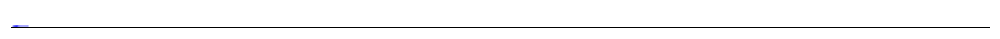

Mean conservation (bits) = 0.032049298346210106
Mean KL Div against background (bits) = 1.9679329305814974


In [8]:
#Define sequence template for optimus

sequence_template = 'N'*50
sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])

#Visualize background sequence distribution

save_figs = True
plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=50)

#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy
x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)
print("Mean conservation (bits) = " + str(x_mean_conservation))

#Calculate mean training set kl-divergence against background
x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)
kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)
x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)
print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))



In [9]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 50
n_samples = 128
sample_mode = 'st'
#sample_mode = 'gumbel'

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)

#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'
predictor = load_model(predictor_path)
predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [10]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(1, seq_length, 4), name='input_logits')

pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask = sampler(dummy_class, input_logits)

scrambler_model = Model([input_logits, dummy_class], [pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.trainable = False
scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [14]:
#open all score and reshape as needed 

file_names = [
    "_1_dropout_autoscrambler_" + dataset_name +"_importance_scores_test.npy",
    "_10_dropout_autoscrambler_" + dataset_name +"_importance_scores_test.npy",
    "perturbation_"+ dataset_name +  "_importance_scores_test.npy",
    "deepexplain_" + dataset_name + "_method_gradient_importance_scores_test.npy",
    "deeplift_" + dataset_name + "_method_guided_backprop_importance_scores_test.npy",
    "deepexplain_" + dataset_name + "_method_rescale_importance_scores_test.npy",
    "deepshap_" + dataset_name + "_importance_scores_test.npy",
    "deepexplain_" + dataset_name +  "_method_integrated_gradients_importance_scores_test.npy",
    "extremal_" + dataset_name +  "_mode_preserve_perturbation_blur_area_02_importance_scores_test.npy",
    "extremal_" + dataset_name +  "_mode_preserve_perturbation_fade_area_02_importance_scores_test.npy",
    "pytorch_saliency_" + dataset_name +  "_smaller_blur_less_penalty_importance_scores_test.npy",
    "sufficient_input_subsets_" + dataset_name +  "_dynamic_thresh_08_mean_importance_scores_test.npy",
    "autoscrambler_no_bg_target_lum_01_weight_10_" + dataset_name +  "_importance_scores_test.npy",
    "l2x_" + dataset_name +  "_importance_scores_test.npy",
    "invase_" + dataset_name +  "_conv_importance_scores_test.npy",
]
#deepexplain_optimus_utr_OR_logic_synth_1_start_2_stops_method_integrated_gradients_importance_scores_test.npy

model_names =[
    "scrambler_weight_1",
    "scrambler_weight_10",
    "perturbation",
    "gradient",
    "guided_backprop",
    "deeplift",
    "deepshap",
    "integrated_gradients",
    "torchray_blur",
    "torchray_fade",
    "saliency_model",
    "sis_mean",
    "zero_scrambler",
    "l2x",
    "invase",
]

model_importance_scores_test = [np.load("./" + file_name) for file_name in file_names]

for scores in model_importance_scores_test:
    print (scores.shape)

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape[-1] > 1 :
        model_importance_scores_test[model_i] = np.sum(model_importance_scores_test[model_i], axis=-1, keepdims=True)

for scores in model_importance_scores_test:
    print (scores.shape)
    
#reshape for mse script -> if not (3008, 1, 50, 1) make it that shape 
idealShape = model_importance_scores_test[0].shape
print (idealShape)

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape != idealShape:
        model_importance_scores_test[model_i] = np.expand_dims(model_importance_scores_test[model_i], 1)
        
for scores in model_importance_scores_test:
    print (scores.shape)


(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 50, 4)
(512, 50, 4)
(512, 1, 50, 4)
(512, 50, 4)
(512, 50, 4)
(512, 50, 4)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 4)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 50, 1)
(512, 50, 1)
(512, 1, 50, 1)
(512, 50, 1)
(512, 50, 1)
(512, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)


In [15]:

on_state_logit_val = 50.
print (x_test.shape)

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

print (x_test_logits.shape)
print (dummy_test.shape)


x_test_squeezed = np.squeeze(x_test)
y_pred_ref = predictor.predict([x_test_squeezed], batch_size=32, verbose=True)[0]

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)



(512, 1, 50, 4)
(512, 1, 50, 4)
(512, 1)
512/512 [==============================] - 0s 78us/step


In [16]:

feature_quantiles = [0.76, 0.82, 0.88]

for name in model_names:
    for quantile in feature_quantiles:
        totalName = name + "_" + str(quantile).replace(".","_") + "_quantile_MSE"
        data_df[totalName] = None
    
print (data_df.columns)

Index(['Unnamed: 0', 'utr', 'gt', 'orig',
       'Dropout scrambler weight 1_0_76_quantile_MSE',
       'Dropout scrambler weight 1_0_82_quantile_MSE',
       'Dropout scrambler weight 1_0_88_quantile_MSE',
       'Dropout scrambler weight 10_0_76_quantile_MSE',
       'Dropout scrambler weight 10_0_82_quantile_MSE',
       'Dropout scrambler weight 10_0_88_quantile_MSE',
       'perturbation_0_76_quantile_MSE', 'perturbation_0_82_quantile_MSE',
       'perturbation_0_88_quantile_MSE', 'gradient_0_76_quantile_MSE',
       'gradient_0_82_quantile_MSE', 'gradient_0_88_quantile_MSE',
       'guided_backprop_0_76_quantile_MSE',
       'guided_backprop_0_82_quantile_MSE',
       'guided_backprop_0_88_quantile_MSE', 'deeplift_0_76_quantile_MSE',
       'deeplift_0_82_quantile_MSE', 'deeplift_0_88_quantile_MSE',
       'deepshap_0_76_quantile_MSE', 'deepshap_0_82_quantile_MSE',
       'deepshap_0_88_quantile_MSE', 'integrated_gradients_0_76_quantile_MSE',
       'integrated_gradients_0_82_qua

In [17]:
#finding MSE of sequences generated using the var. methods as importnace scores in each quantile of interest

feature_quantiles = [0.76, 0.82, 0.88]
from sklearn import metrics
model_mses = []
for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_mses = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][feature_quantile_i, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        n_to_test = importance_scores_test.shape[0] // batch_size * batch_size
        importance_scores_test = importance_scores_test[:n_to_test]
        
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:n_to_test], axis=-1), axis=-1)

        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val
        
        top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:n_to_test]

        _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:n_to_test]], batch_size=batch_size)
        print (samples_test.shape)
        msesPerPoint = []
        for data_ix in range(samples_test.shape[0]) :
            #for each sample, look at kl divergence for the 128 size batch generated 
            #for MSE, just track the pred vs original pred 
            if data_ix % 1000 == 0 :
                print("Processing example " + str(data_ix) + "...")
            
            #from optimus R^2, MSE, Pearson R script 
            justPred = np.expand_dims(np.expand_dims(x_test[data_ix, 0, :, :], axis=0), axis=-1)
            justPredReshape = np.reshape(justPred, (1,50,4))
            
            expanded = np.expand_dims(samples_test[data_ix, :, 0, :, :], axis=-1) #batch size is 128 
            expandedReshape = np.reshape(expanded, (n_samples, 50,4))
            
            y_test_hat_ref = predictor.predict(x=justPredReshape, batch_size=1)[0][0]
            
            y_test_hat = predictor.predict(x=[expandedReshape], batch_size=32)
            
            pwmGenerated = y_test_hat.tolist()
            tempOriginals = [y_test_hat_ref]*y_test_hat.shape[0]
            
            asArrayOrig = np.array(tempOriginals)
            asArrayGen = np.array(pwmGenerated)
            squeezed = np.squeeze(asArrayGen)
            mse = metrics.mean_squared_error(asArrayOrig, squeezed)
            #msesPerPoint.append(mse)
            totalName = model_names[model_i] + "_" + str(feature_quantile).replace(".","_") + "_quantile_MSE"
            data_df.at[data_ix, totalName] = mse
            msesPerPoint.append(mse)
        msesPerPoint = np.array(msesPerPoint)
        feature_quantile_mses.append(msesPerPoint)
    model_mses.append(feature_quantile_mses)

Benchmarking model 'scrambler_weight_1'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking model 'scrambler_weight_10'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking model 'perturbation'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking model 'gradient'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking mo

--- MSEs ---
--------------------   0.76   0.82   0.88
SCRAMBLER_WEIGHT_1     0.30   0.35   0.55
SCRAMBLER_WEIGHT_10    0.34   0.37   0.58
PERTURBATION           0.33   0.39   0.54
GRADIENT               0.47   0.57   0.91
GUIDED_BACKPROP        1.37   1.41   1.49
DEEPLIFT               0.39   0.44   0.69
DEEPSHAP               0.58   0.64   0.88
INTEGRATED_GRADIENTS   0.39   0.45   0.71
TORCHRAY_BLUR          0.62   0.73   0.77
TORCHRAY_FADE          0.72   0.84   0.90
SALIENCY_MODEL         0.60   0.83   1.26
SIS_MEAN               0.41   0.50   1.23
ZERO_SCRAMBLER         1.69   1.76   1.81
L2X                    1.54   1.58   1.65
INVASE                 1.35   1.41   1.51



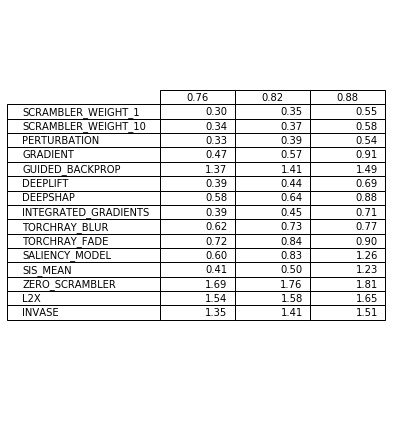

In [18]:
#Store benchmark results as tables

mse_table = np.zeros((len(model_mses), len(model_mses[0])))

for i, model_name in enumerate(model_names) :
    
    for j, feature_quantile in enumerate(feature_quantiles) :
        
        mse_table[i, j] = np.mean(model_mses[i][j])

#Plot and store mse table
f = plt.figure(figsize = (4, 6))

cells = np.round(mse_table, 3).tolist()

print("--- MSEs ---")
max_len = np.max([len(model_name.upper().replace("\n", " ")) for model_name in model_names])
print(("-" * max_len) + "   " + "   ".join([(str(feature_quantile) + "0")[:4] for feature_quantile in feature_quantiles]))
for i in range(len(cells)) :
    
    curr_len = len([model_name.upper().replace("\n", " ") for model_name in model_names][i])
    row_str = [model_name.upper().replace("\n", " ") for model_name in model_names][i] + (" " * (max_len - curr_len))
    
    for j in range(len(cells[i])) :
        cells[i][j] = (str(cells[i][j]) + "00000")[:4]
        
        row_str += "   " + cells[i][j]
    
    print(row_str)

print("")

table = plt.table(cellText=cells, rowLabels=[model_name.upper().replace("\n", " ") for model_name in model_names], colLabels=feature_quantiles, loc='center')

ax = plt.gca()
#f.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

plt.tight_layout()

if save_figs :
    plt.savefig(dataset_name + "_mse_table.png", dpi=300, transparent=True)
    plt.savefig(dataset_name + "_mse_table.eps")

plt.show()


0.76
scrambler_weight_1
scrambler_weight_10
perturbation
gradient
guided_backprop
deeplift
deepshap
integrated_gradients
torchray_blur
torchray_fade
saliency_model
sis_mean
zero_scrambler
l2x
invase
scrambler_weight_1 0.5 0.2718172380404407
scrambler_weight_1 0.8 0.4043595844484634
scrambler_weight_1 0.9 0.5038437869342768
scrambler_weight_1 0.95 0.6129144302366086
scrambler_weight_10 0.5 0.29683539173439766
scrambler_weight_10 0.8 0.4388611577144402
scrambler_weight_10 0.9 0.5541474866982118
scrambler_weight_10 0.95 0.7303558415254201
perturbation 0.5 0.2891520606142482
perturbation 0.8 0.42192209897355076
perturbation 0.9 0.5438559551359867
perturbation 0.95 0.7287278807491478
gradient 0.5 0.42165598238437724
gradient 0.8 0.6490433050832694
gradient 0.9 0.7742492722011258
gradient 0.95 0.9481476098187416
guided_backprop 0.5 1.071066318359271
guided_backprop 0.8 2.291385832307965
guided_backprop 0.9 2.831926501452524
guided_backprop 0.95 3.2972688277453157
deeplift 0.5 0.3159466814979

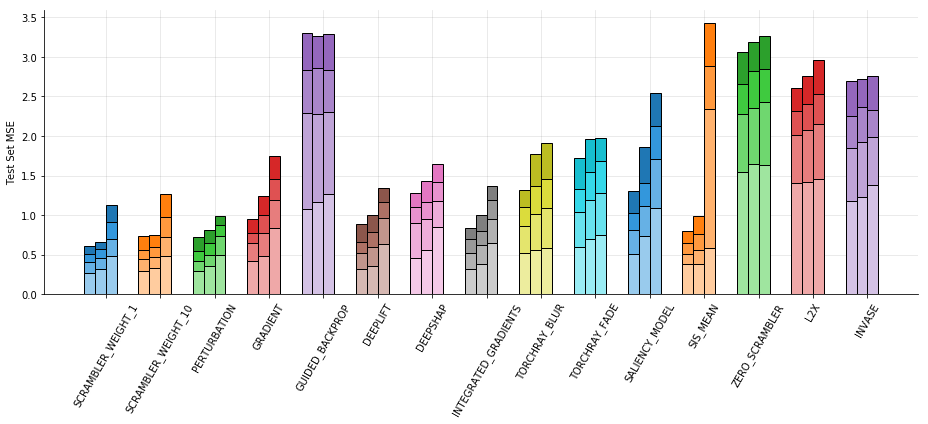

In [20]:
#use numbe nts 
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(13, 6))

#benchmark_name = "benchmark_optimus_doubledope_IF_uORF_Only_nts_barplot"

save_figs = True

width = 0.2

max_y_val = None

cm = plt.get_cmap('viridis_r')

shades = [0.4, 0.6, 0.8, 1]

quantiles = [0.5, 0.8, 0.9, 0.95]

feature_quantiles = [0.76, 0.82, 0.88]

nts = [12, 9, 6]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

to_save = {'model':[], 'feature_quantile':[], 'mse_quantile':[], 'value':[]}

for i in range(1, len(feature_quantiles) + 1) :
    print (feature_quantiles[i-1])
    for j in range(len(model_names)):
        print (model_names[j])
        kl_div_samples = model_mses[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(kl_div_samples, q=quantile)
        
    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            print (model_names[j], quantiles[l], val )
            to_save['model'].append(model_names[j])
            to_save['feature_quantile'].append(feature_quantiles[i-1])
            to_save['mse_quantile'].append(quantiles[l])
            to_save['value'].append(val)
            
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            #if l == len(quantiles) - 1 and (max_y_val is None or val < 0.95 * max_y_val) :
            #    numberNTs = str(nts[i-1])
            #    plt.text(xs[j], val, "Top\n" + numberNTs +"\n nts", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

plt.xticks([i + 2.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set MSE")

#max_y_val = np.max(results) * 1.1

if max_y_val is not None :
    plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
'''
plt.legend(fontsize=9, frameon=True, loc='best')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')
'''
plt.tight_layout()

if save_figs :
    plt.savefig(dataset_name + "nolegend.png", dpi=300, transparent=True)
    plt.savefig(dataset_name + "nolegend.eps")

plt.show()

to_save = pd.DataFrame(to_save)
to_save.to_csv(dataset_name + "_6_9_12_quantiles.csv")

In [21]:
#save df ?
data_df.to_csv(dataset_name + "_6_9_12_results.csv")
print (dataset_name + "_6_9_12_results.csv")
print (data_df.columns)

optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512_6_9_12_results.csv
Index(['Unnamed: 0', 'utr', 'gt', 'orig',
       'dropout scrambler weight 1_0_76_quantile_MSE',
       'dropout scrambler weight 1_0_82_quantile_MSE',
       'dropout scrambler weight 1_0_88_quantile_MSE',
       'dropout scrambler weight 10_0_76_quantile_MSE',
       'dropout scrambler weight 10_0_82_quantile_MSE',
       'dropout scrambler weight 10_0_88_quantile_MSE',
       'perturbation_0_76_quantile_MSE', 'perturbation_0_82_quantile_MSE',
       'perturbation_0_88_quantile_MSE', 'gradient_0_76_quantile_MSE',
       'gradient_0_82_quantile_MSE', 'gradient_0_88_quantile_MSE',
       'integrated_gradients_0_76_quantile_MSE',
       'integrated_gradients_0_82_quantile_MSE',
       'integrated_gradients_0_88_quantile_MSE', 'deeplift_0_76_quantile_MSE',
       'deeplift_0_82_quantile_MSE', 'deeplift_0_88_quantile_MSE',
       'deepshap_0_76_quantile_MSE', 'deepshap_0_82_quantile_MSE',
       'd

In [22]:
#modifyign plot examples script for scrambler plots 

def getPWMTest(model_name, x_test):

    save_dir = 'saved_models'
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name)
    scrambler_model = load_model(model_path, custom_objects={
        'st_sampled_softmax' : st_sampled_softmax,
        'gumbel_softmax': gumbel_softmax
    })

    print('Loaded scrambler model %s ' % (model_path))
    
    s_test = np.zeros((x_test.shape[0], 1))

    _, pwm_test, sample_test,_ = scrambler_model.predict(x=[x_test, s_test])

    return pwm_test


model_name_0125 = "autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_0125improvedIFDataset_importanceScores.h5"
model_name_025 = "autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_025improvedIFDataset_importanceScores.h5"

pwm_test_0125 =  getPWMTest(model_name_0125, x_test)

pwm_test_025 = getPWMTest(model_name_025, x_test)

#graph some examples 
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, plot_sequence_template=False, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        if sequence_template[i] == 'N' :
            mutability_score = np.sum(importance_scores[:, i])
            dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)
        elif plot_sequence_template :
            dna_letter_at(ref_seq[i], i + 0.5, 0, max_score, ax, color='black')

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    #plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()



Loaded scrambler model saved_models/autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_0125improvedIFDataset_importanceScores.h5 
Loaded scrambler model saved_models/autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_025improvedIFDataset_importanceScores.h5 


Test pattern = 0:
 - Prediction (original) = -0.7


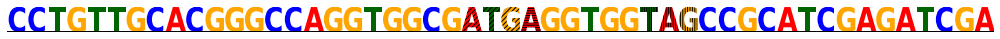

Model = 'dropout scrambler weight 1'...


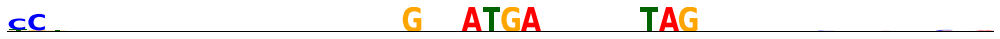

Model = 'dropout scrambler weight 10'...


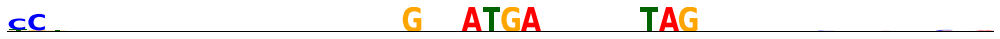

Model = 'perturbation'...


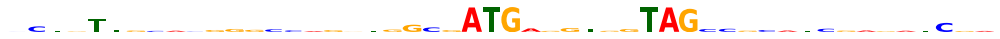

Model = 'gradient'...


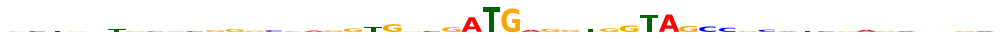

Model = 'integrated_gradients'...


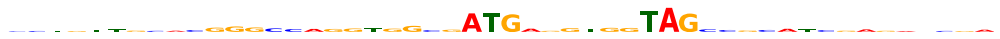

Model = 'deeplift'...


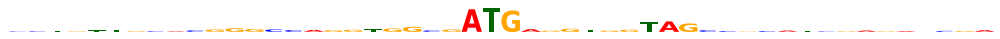

Model = 'deepshap'...


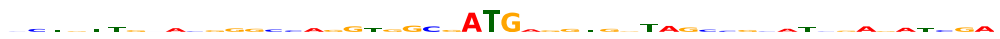

Test pattern = 1:
 - Prediction (original) = -1.3


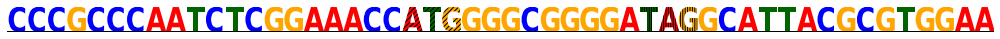

Model = 'dropout scrambler weight 1'...


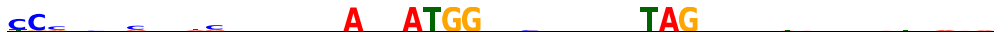

Model = 'dropout scrambler weight 10'...


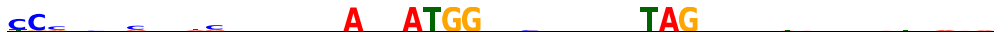

Model = 'perturbation'...


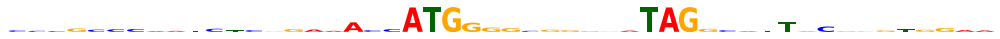

Model = 'gradient'...


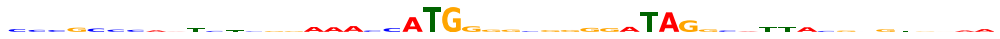

Model = 'integrated_gradients'...


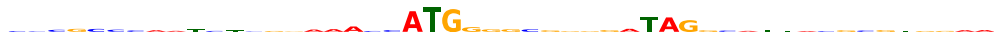

Model = 'deeplift'...


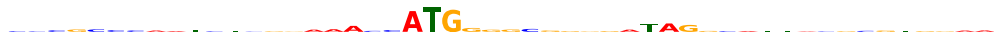

Model = 'deepshap'...


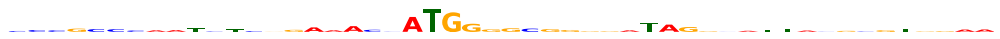

Test pattern = 2:
 - Prediction (original) = -0.7


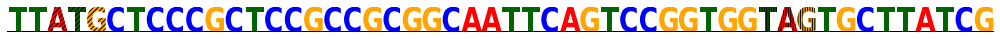

Model = 'dropout scrambler weight 1'...


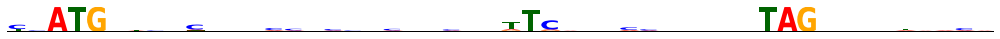

Model = 'dropout scrambler weight 10'...


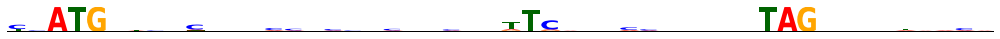

Model = 'perturbation'...


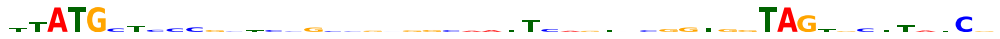

Model = 'gradient'...


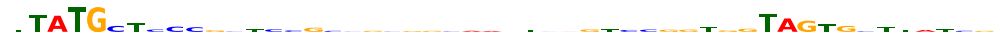

Model = 'integrated_gradients'...


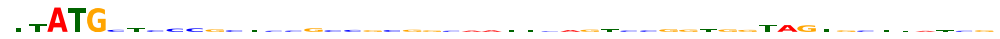

Model = 'deeplift'...


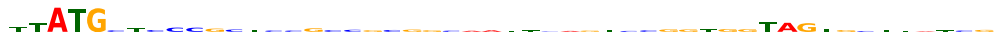

Model = 'deepshap'...


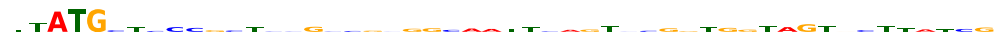

Test pattern = 3:
 - Prediction (original) = -1.1


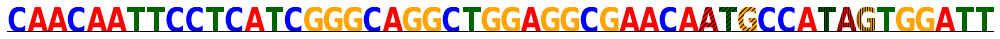

Model = 'dropout scrambler weight 1'...


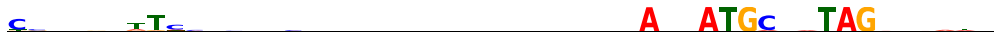

Model = 'dropout scrambler weight 10'...


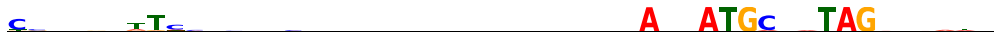

Model = 'perturbation'...


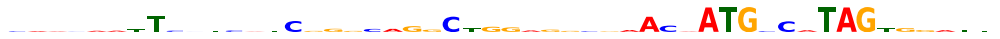

Model = 'gradient'...


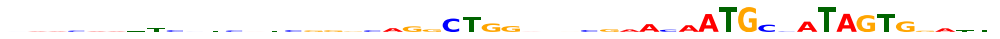

Model = 'integrated_gradients'...


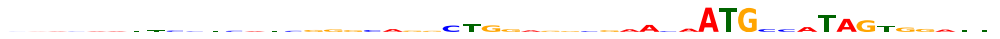

Model = 'deeplift'...


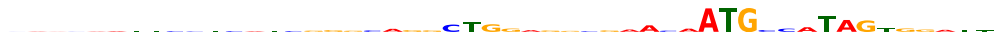

Model = 'deepshap'...


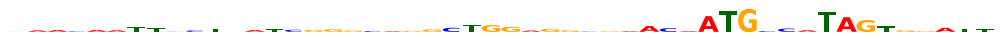

Test pattern = 4:
 - Prediction (original) = -0.7


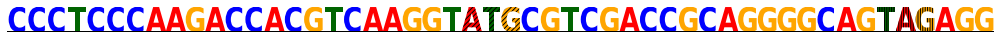

Model = 'dropout scrambler weight 1'...


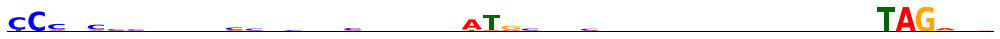

Model = 'dropout scrambler weight 10'...


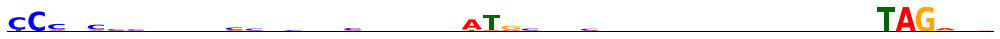

Model = 'perturbation'...


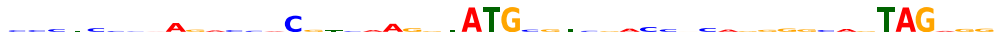

Model = 'gradient'...


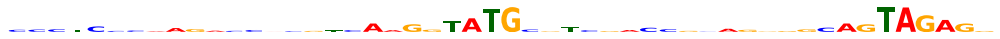

Model = 'integrated_gradients'...


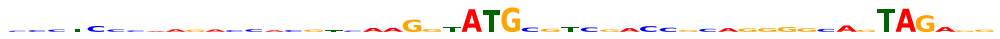

Model = 'deeplift'...


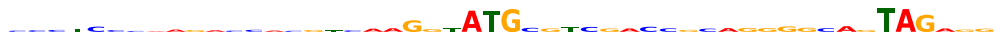

Model = 'deepshap'...


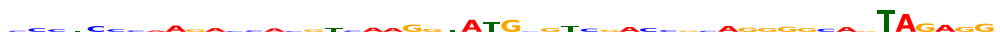

Test pattern = 5:
 - Prediction (original) = -0.7


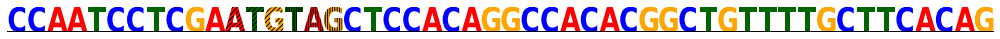

Model = 'dropout scrambler weight 1'...


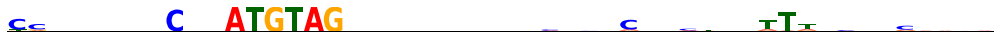

Model = 'dropout scrambler weight 10'...


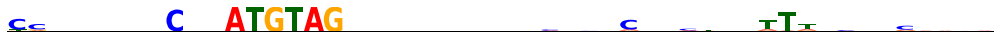

Model = 'perturbation'...


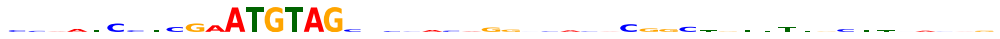

Model = 'gradient'...


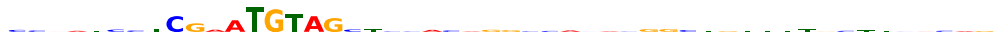

Model = 'integrated_gradients'...


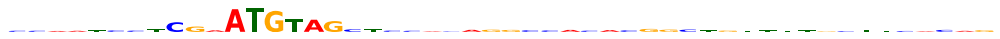

Model = 'deeplift'...


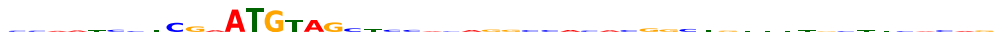

Model = 'deepshap'...


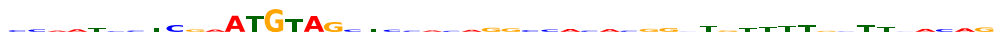

Test pattern = 6:
 - Prediction (original) = -0.5


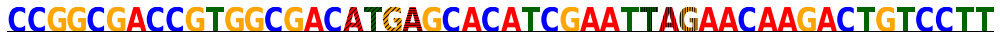

Model = 'dropout scrambler weight 1'...


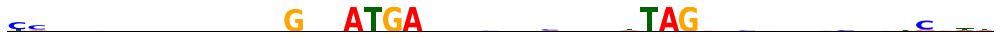

Model = 'dropout scrambler weight 10'...


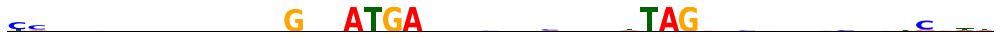

Model = 'perturbation'...


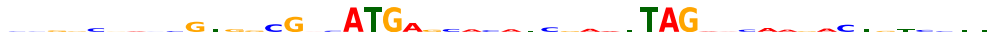

Model = 'gradient'...


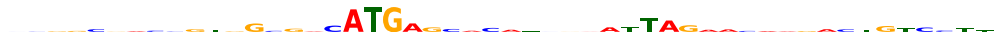

Model = 'integrated_gradients'...


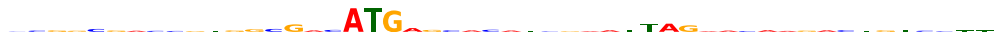

Model = 'deeplift'...


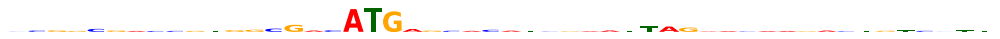

Model = 'deepshap'...


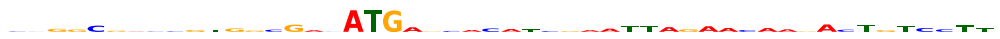

Test pattern = 7:
 - Prediction (original) = -0.6


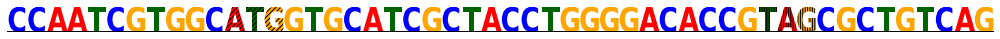

Model = 'dropout scrambler weight 1'...


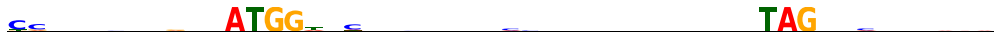

Model = 'dropout scrambler weight 10'...


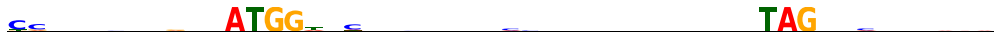

Model = 'perturbation'...


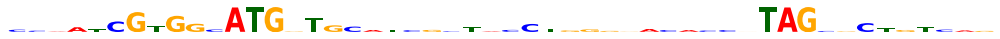

Model = 'gradient'...


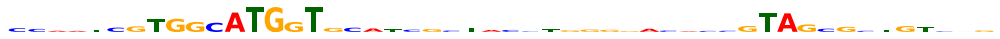

Model = 'integrated_gradients'...


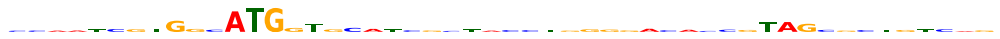

Model = 'deeplift'...


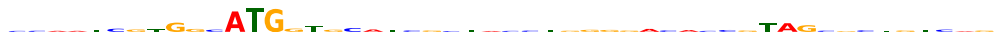

Model = 'deepshap'...


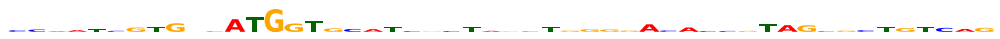

Test pattern = 8:
 - Prediction (original) = -0.9


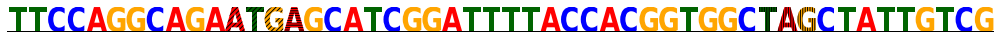

Model = 'dropout scrambler weight 1'...


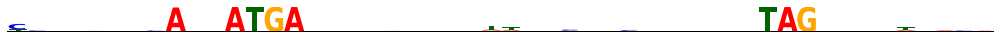

Model = 'dropout scrambler weight 10'...


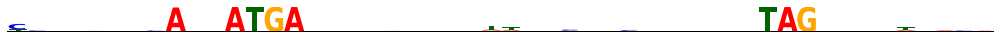

Model = 'perturbation'...


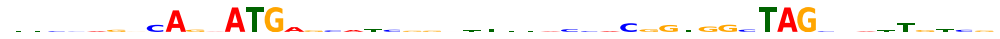

Model = 'gradient'...


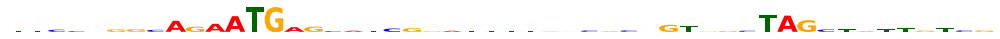

Model = 'integrated_gradients'...


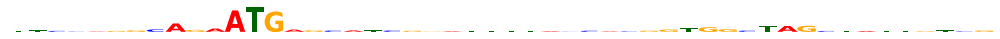

Model = 'deeplift'...


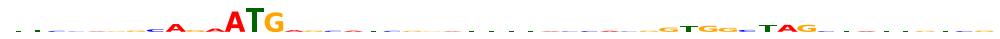

Model = 'deepshap'...


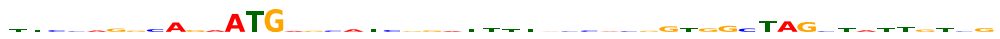

Test pattern = 9:
 - Prediction (original) = -0.7


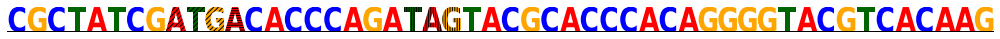

Model = 'dropout scrambler weight 1'...


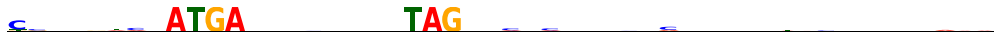

Model = 'dropout scrambler weight 10'...


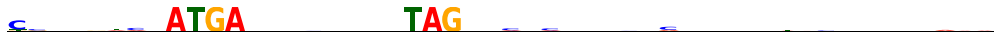

Model = 'perturbation'...


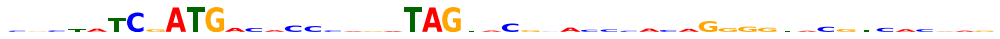

Model = 'gradient'...


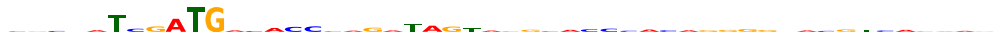

Model = 'integrated_gradients'...


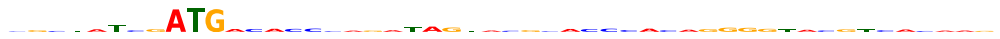

Model = 'deeplift'...


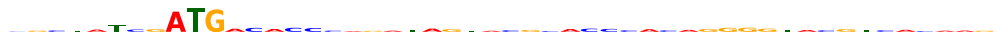

Model = 'deepshap'...


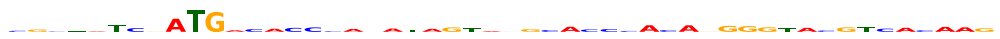

Test pattern = 10:
 - Prediction (original) = -0.7


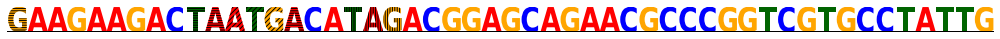

Model = 'dropout scrambler weight 1'...


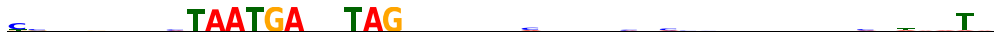

Model = 'dropout scrambler weight 10'...


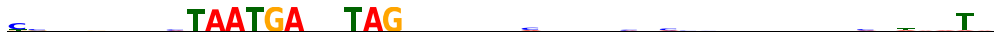

Model = 'perturbation'...


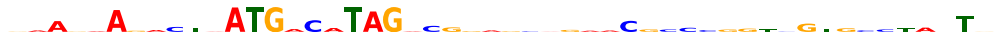

Model = 'gradient'...


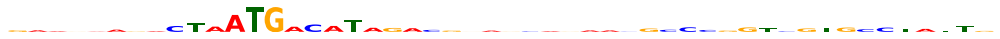

Model = 'integrated_gradients'...


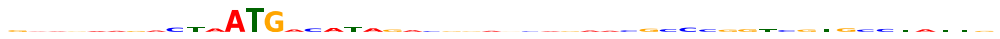

Model = 'deeplift'...


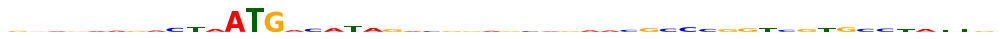

Model = 'deepshap'...


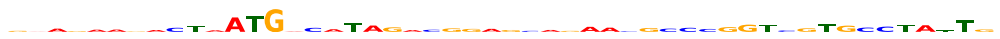

Test pattern = 11:
 - Prediction (original) = -1.0


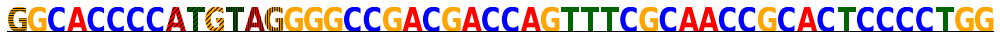

Model = 'dropout scrambler weight 1'...


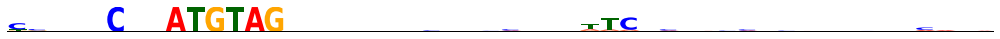

Model = 'dropout scrambler weight 10'...


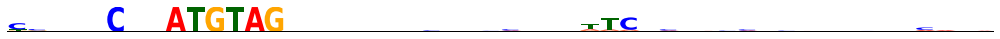

Model = 'perturbation'...


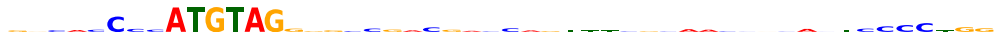

Model = 'gradient'...


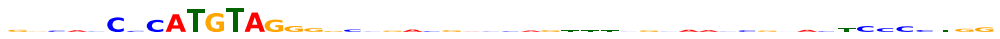

Model = 'integrated_gradients'...


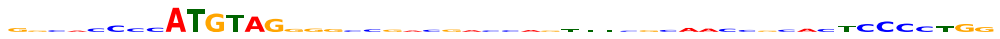

Model = 'deeplift'...


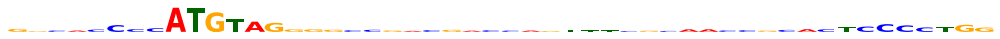

Model = 'deepshap'...


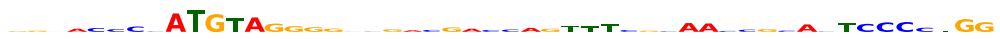

Test pattern = 12:
 - Prediction (original) = -1.4


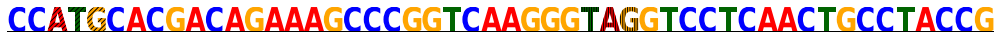

Model = 'dropout scrambler weight 1'...


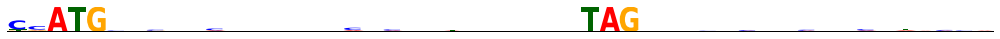

Model = 'dropout scrambler weight 10'...


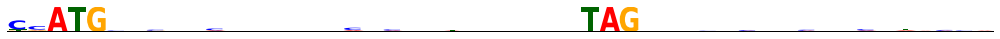

Model = 'perturbation'...


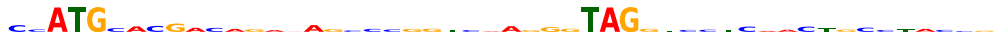

Model = 'gradient'...


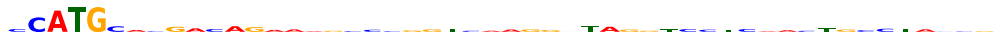

Model = 'integrated_gradients'...


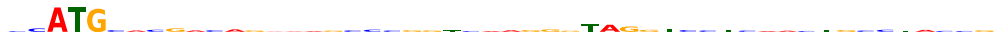

Model = 'deeplift'...


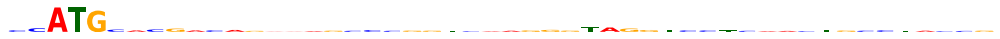

Model = 'deepshap'...


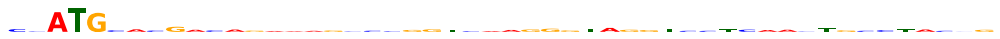

Test pattern = 13:
 - Prediction (original) = -1.1


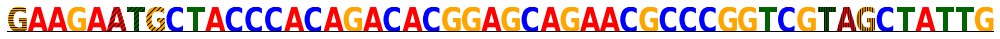

Model = 'dropout scrambler weight 1'...


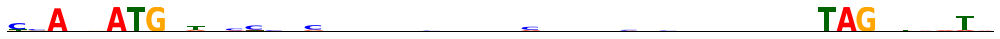

Model = 'dropout scrambler weight 10'...


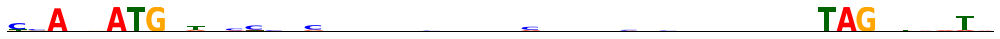

Model = 'perturbation'...


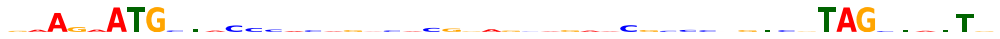

Model = 'gradient'...


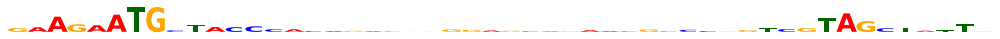

Model = 'integrated_gradients'...


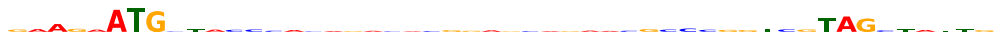

Model = 'deeplift'...


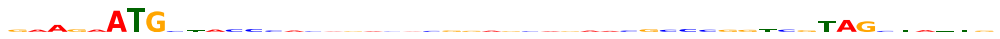

Model = 'deepshap'...


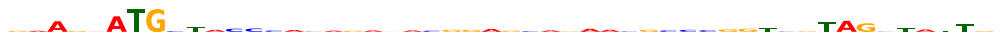

Test pattern = 14:
 - Prediction (original) = -1.3


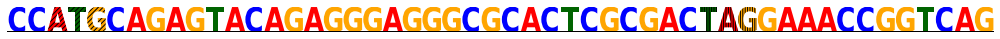

Model = 'dropout scrambler weight 1'...


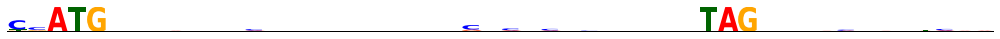

Model = 'dropout scrambler weight 10'...


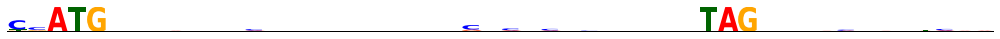

Model = 'perturbation'...


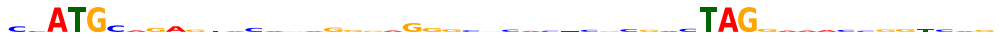

Model = 'gradient'...


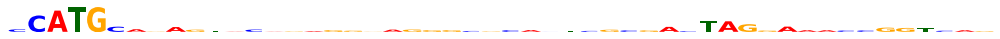

Model = 'integrated_gradients'...


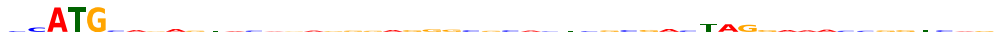

Model = 'deeplift'...


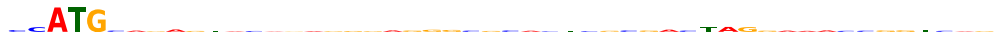

Model = 'deepshap'...


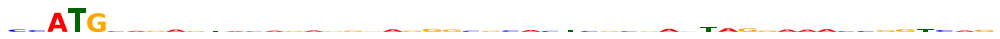

Test pattern = 15:
 - Prediction (original) = -0.9


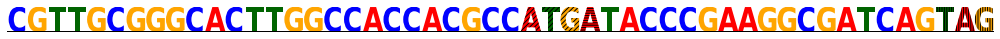

Model = 'dropout scrambler weight 1'...


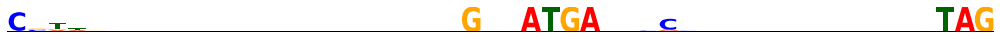

Model = 'dropout scrambler weight 10'...


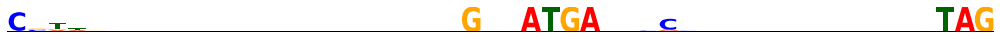

Model = 'perturbation'...


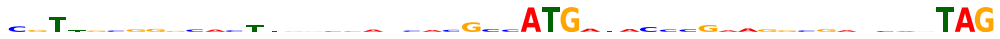

Model = 'gradient'...


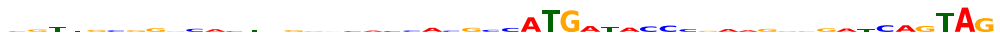

Model = 'integrated_gradients'...


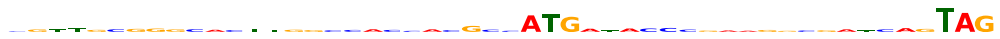

Model = 'deeplift'...


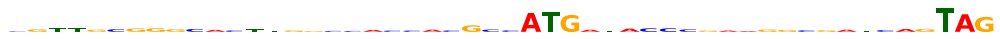

Model = 'deepshap'...


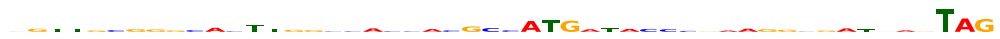

Test pattern = 16:
 - Prediction (original) = -1.1


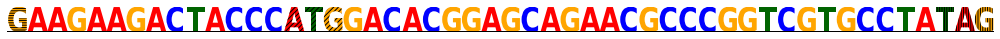

Model = 'dropout scrambler weight 1'...


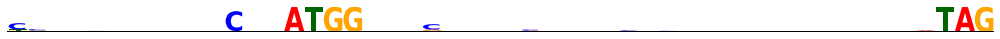

Model = 'dropout scrambler weight 10'...


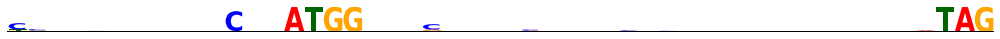

Model = 'perturbation'...


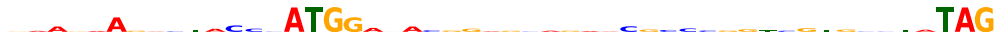

Model = 'gradient'...


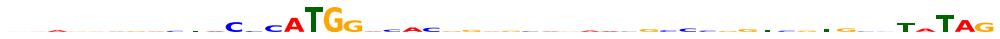

Model = 'integrated_gradients'...


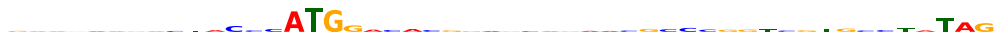

Model = 'deeplift'...


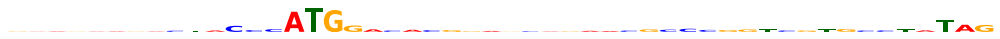

Model = 'deepshap'...


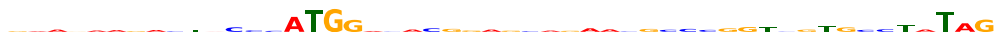

Test pattern = 17:
 - Prediction (original) = -1.3


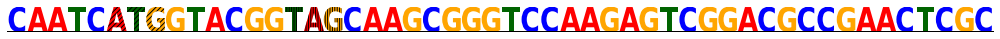

Model = 'dropout scrambler weight 1'...


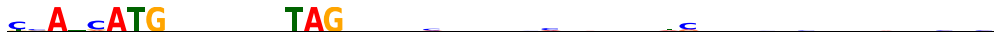

Model = 'dropout scrambler weight 10'...


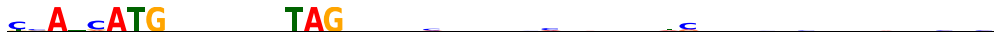

Model = 'perturbation'...


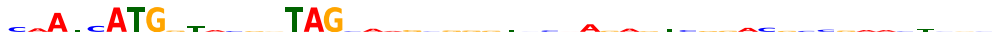

Model = 'gradient'...


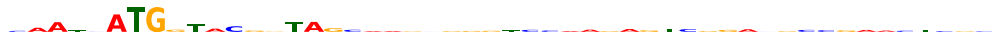

Model = 'integrated_gradients'...


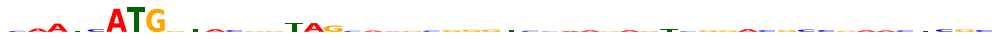

Model = 'deeplift'...


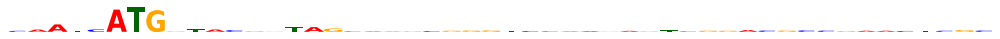

Model = 'deepshap'...


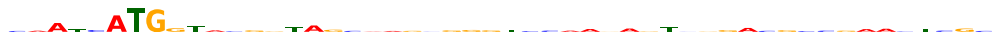

Test pattern = 18:
 - Prediction (original) = -1.3


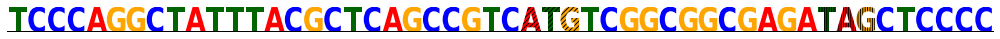

Model = 'dropout scrambler weight 1'...


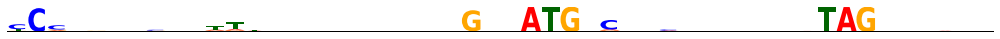

Model = 'dropout scrambler weight 10'...


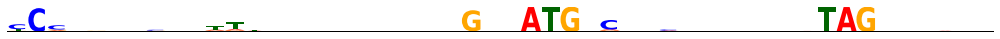

Model = 'perturbation'...


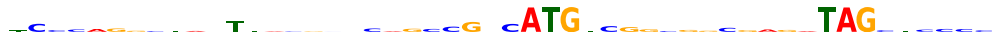

Model = 'gradient'...


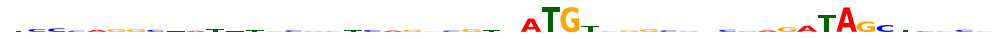

Model = 'integrated_gradients'...


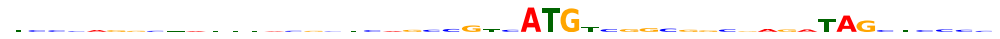

Model = 'deeplift'...


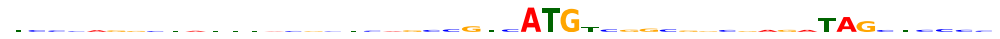

Model = 'deepshap'...


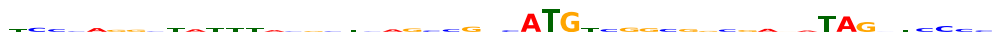

Test pattern = 19:
 - Prediction (original) = -1.5


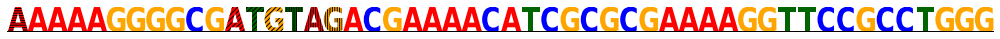

Model = 'dropout scrambler weight 1'...


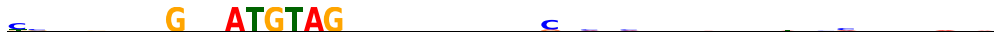

Model = 'dropout scrambler weight 10'...


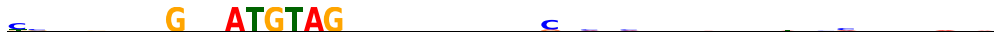

Model = 'perturbation'...


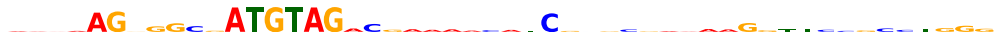

Model = 'gradient'...


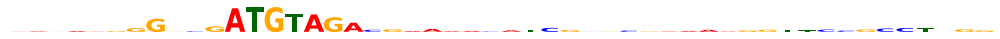

Model = 'integrated_gradients'...


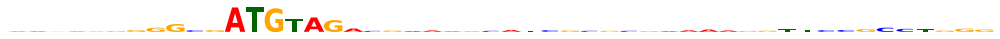

Model = 'deeplift'...


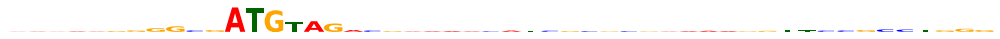

Model = 'deepshap'...


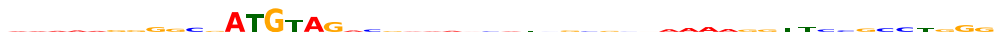

Test pattern = 20:
 - Prediction (original) = -0.6


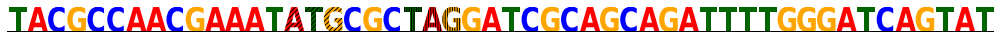

Model = 'dropout scrambler weight 1'...


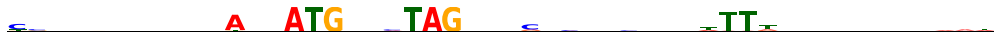

Model = 'dropout scrambler weight 10'...


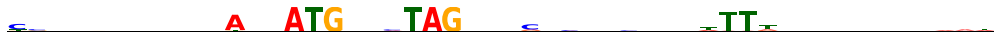

Model = 'perturbation'...


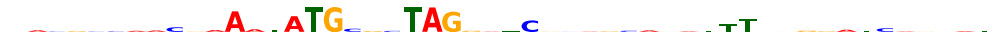

Model = 'gradient'...


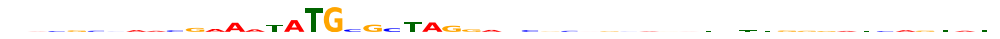

Model = 'integrated_gradients'...


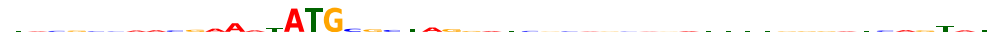

Model = 'deeplift'...


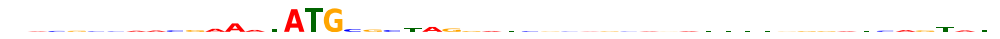

Model = 'deepshap'...


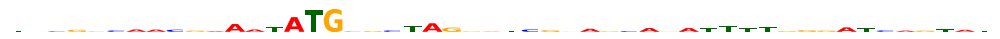

Test pattern = 21:
 - Prediction (original) = -1.0


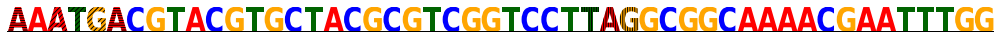

Model = 'dropout scrambler weight 1'...


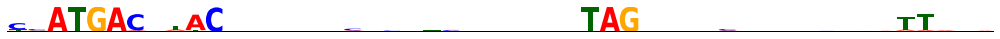

Model = 'dropout scrambler weight 10'...


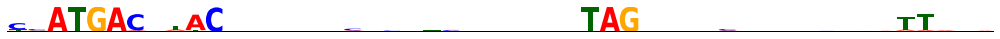

Model = 'perturbation'...


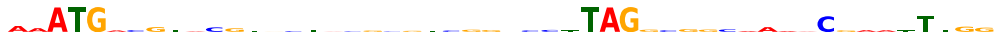

Model = 'gradient'...


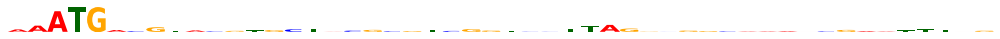

Model = 'integrated_gradients'...


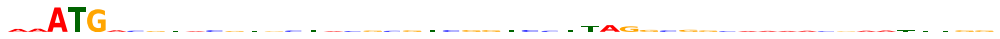

Model = 'deeplift'...


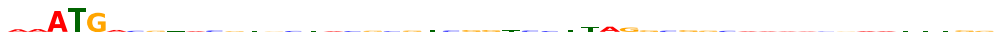

Model = 'deepshap'...


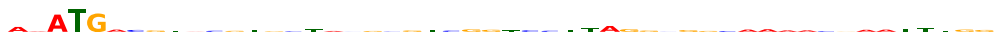

Test pattern = 22:
 - Prediction (original) = -0.4


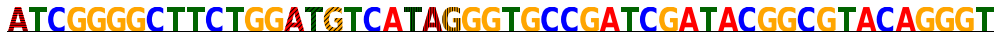

Model = 'dropout scrambler weight 1'...


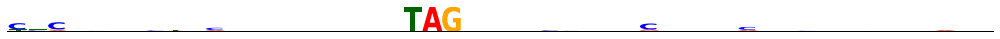

Model = 'dropout scrambler weight 10'...


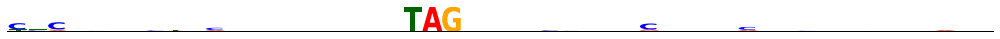

Model = 'perturbation'...


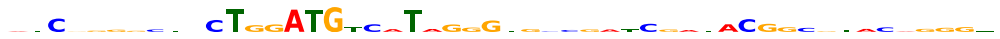

Model = 'gradient'...


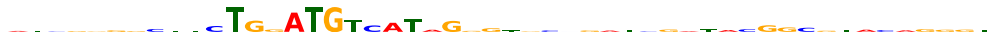

Model = 'integrated_gradients'...


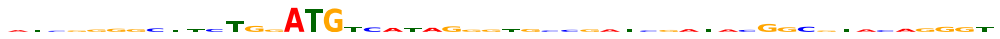

Model = 'deeplift'...


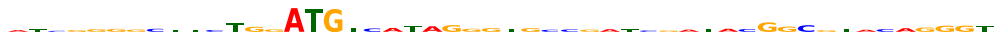

Model = 'deepshap'...


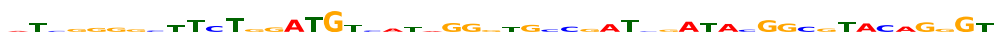

Test pattern = 23:
 - Prediction (original) = -0.6


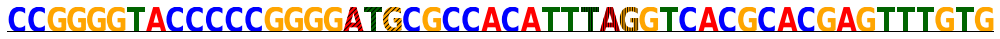

Model = 'dropout scrambler weight 1'...


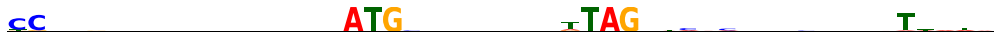

Model = 'dropout scrambler weight 10'...


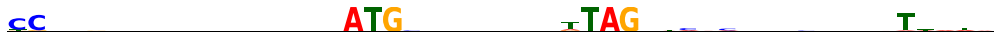

Model = 'perturbation'...


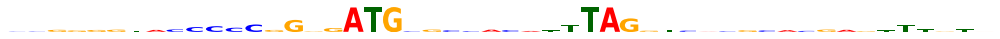

Model = 'gradient'...


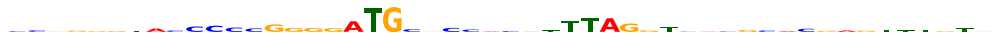

Model = 'integrated_gradients'...


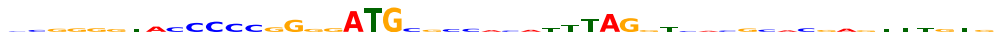

Model = 'deeplift'...


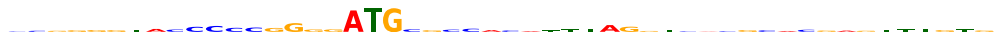

Model = 'deepshap'...


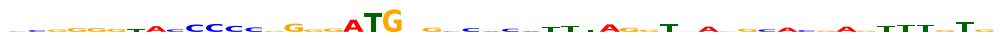

Test pattern = 24:
 - Prediction (original) = -1.0


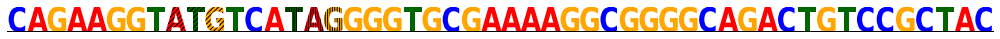

Model = 'dropout scrambler weight 1'...


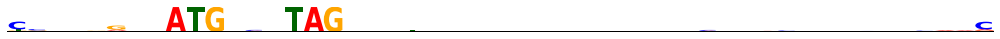

Model = 'dropout scrambler weight 10'...


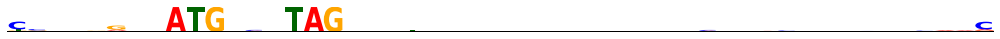

Model = 'perturbation'...


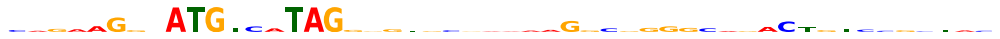

Model = 'gradient'...


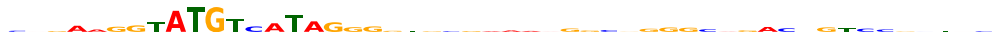

Model = 'integrated_gradients'...


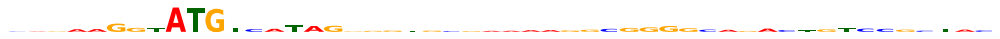

Model = 'deeplift'...


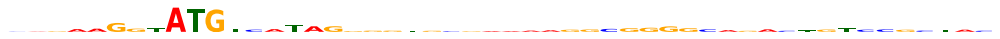

Model = 'deepshap'...


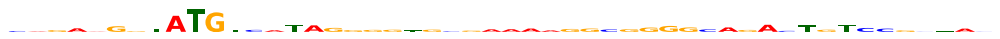

Test pattern = 25:
 - Prediction (original) = -1.2


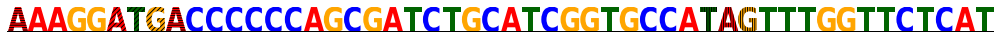

Model = 'dropout scrambler weight 1'...


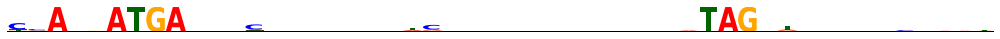

Model = 'dropout scrambler weight 10'...


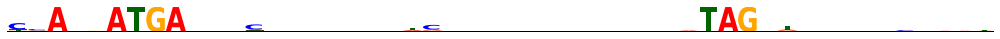

Model = 'perturbation'...


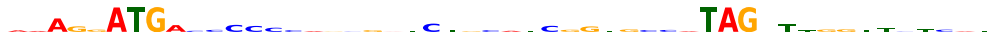

Model = 'gradient'...


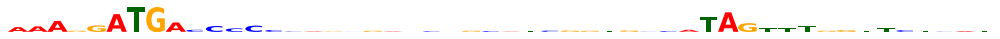

Model = 'integrated_gradients'...


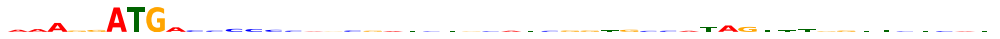

Model = 'deeplift'...


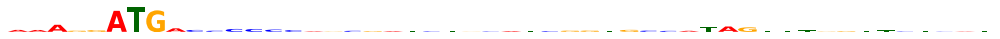

Model = 'deepshap'...


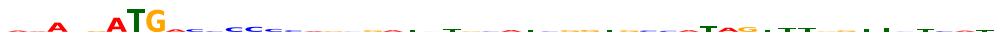

Test pattern = 26:
 - Prediction (original) = -1.4


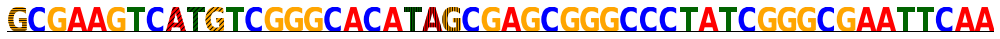

Model = 'dropout scrambler weight 1'...


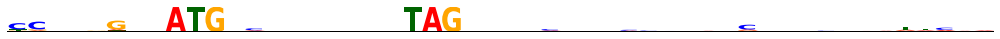

Model = 'dropout scrambler weight 10'...


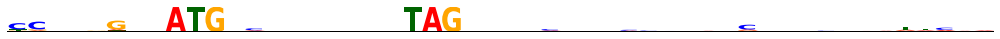

Model = 'perturbation'...


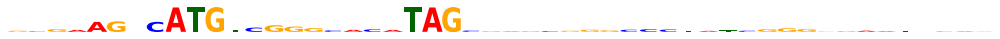

Model = 'gradient'...


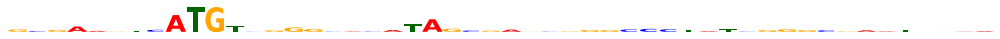

Model = 'integrated_gradients'...


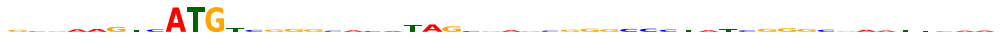

Model = 'deeplift'...


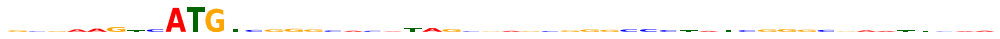

Model = 'deepshap'...


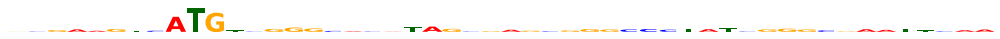

Test pattern = 27:
 - Prediction (original) = -1.2


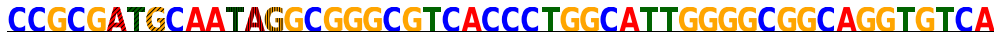

Model = 'dropout scrambler weight 1'...


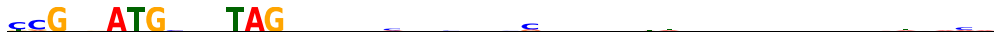

Model = 'dropout scrambler weight 10'...


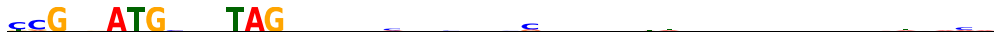

Model = 'perturbation'...


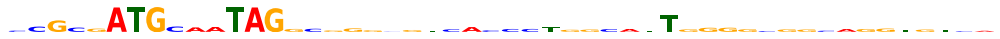

Model = 'gradient'...


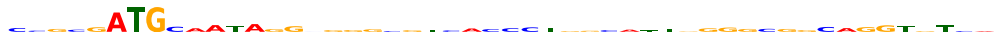

Model = 'integrated_gradients'...


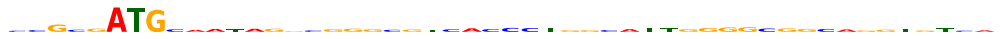

Model = 'deeplift'...


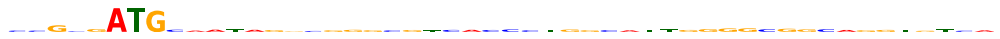

Model = 'deepshap'...


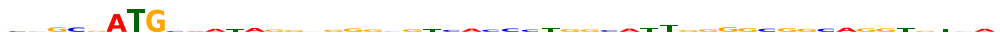

Test pattern = 28:
 - Prediction (original) = -1.0


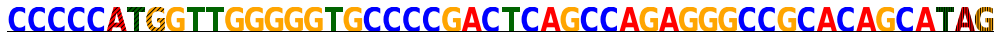

Model = 'dropout scrambler weight 1'...


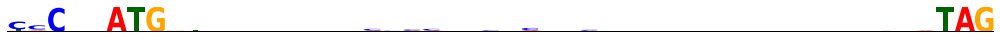

Model = 'dropout scrambler weight 10'...


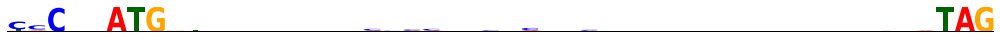

Model = 'perturbation'...


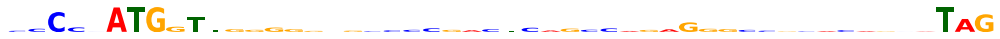

Model = 'gradient'...


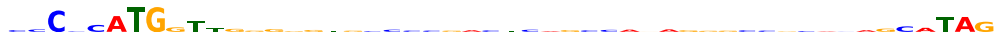

Model = 'integrated_gradients'...


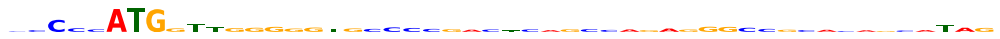

Model = 'deeplift'...


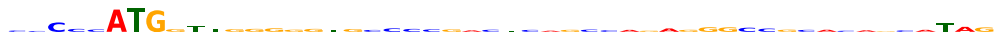

Model = 'deepshap'...


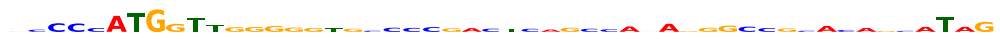

Test pattern = 29:
 - Prediction (original) = -1.1


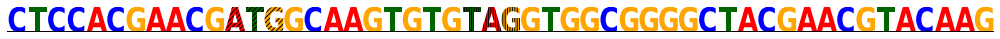

Model = 'dropout scrambler weight 1'...


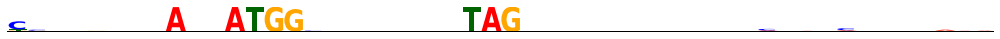

Model = 'dropout scrambler weight 10'...


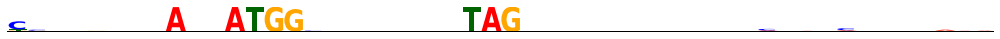

Model = 'perturbation'...


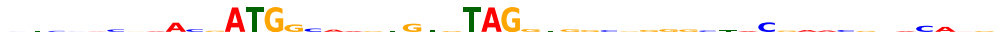

Model = 'gradient'...


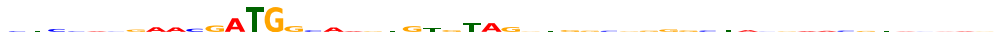

Model = 'integrated_gradients'...


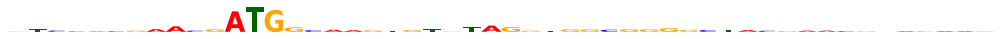

Model = 'deeplift'...


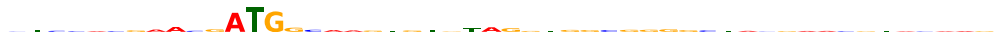

Model = 'deepshap'...


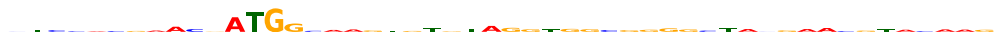

Test pattern = 30:
 - Prediction (original) = -1.0


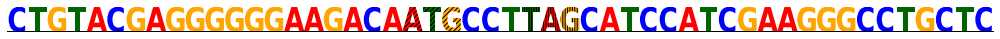

Model = 'dropout scrambler weight 1'...


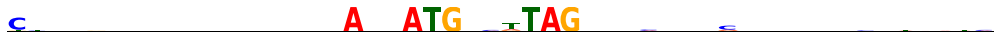

Model = 'dropout scrambler weight 10'...


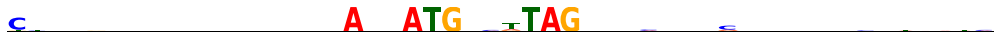

Model = 'perturbation'...


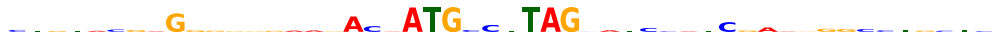

Model = 'gradient'...


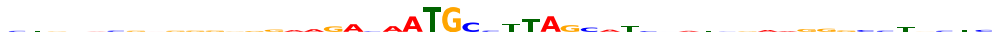

Model = 'integrated_gradients'...


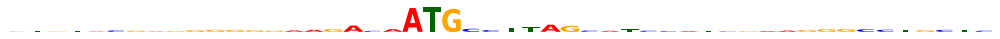

Model = 'deeplift'...


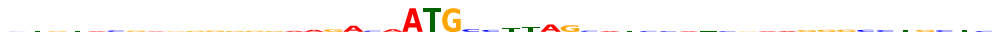

Model = 'deepshap'...


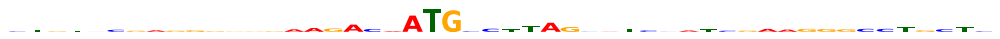

Test pattern = 31:
 - Prediction (original) = -0.5


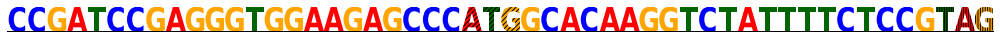

Model = 'dropout scrambler weight 1'...


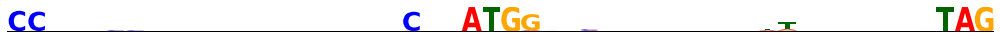

Model = 'dropout scrambler weight 10'...


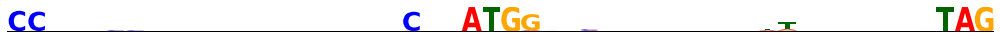

Model = 'perturbation'...


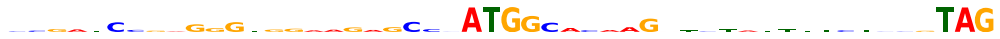

Model = 'gradient'...


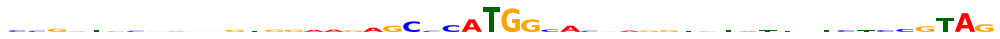

Model = 'integrated_gradients'...


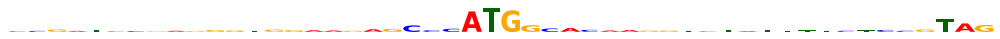

Model = 'deeplift'...


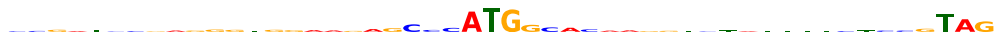

Model = 'deepshap'...


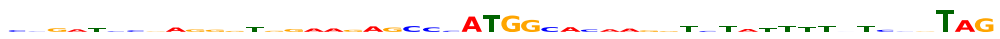

Test pattern = 32:
 - Prediction (original) = -0.6


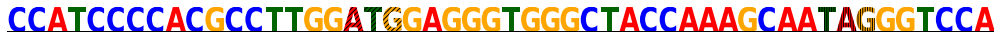

Model = 'dropout scrambler weight 1'...


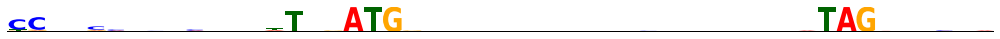

Model = 'dropout scrambler weight 10'...


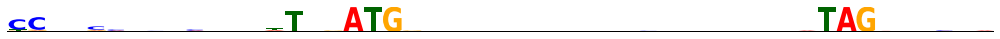

Model = 'perturbation'...


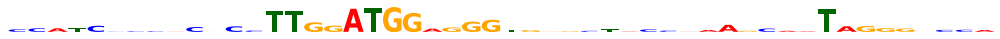

Model = 'gradient'...


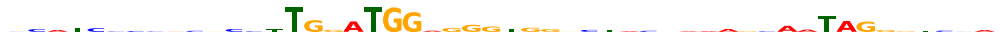

Model = 'integrated_gradients'...


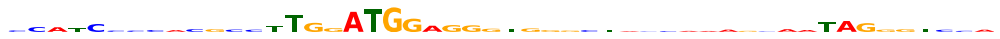

Model = 'deeplift'...


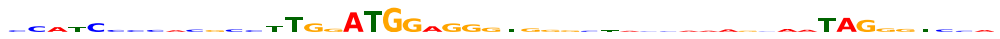

Model = 'deepshap'...


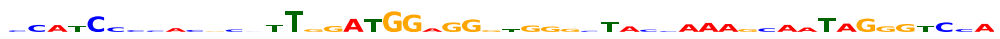

Test pattern = 33:
 - Prediction (original) = -0.8


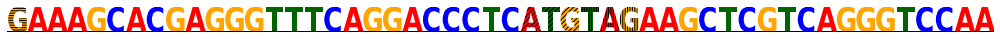

Model = 'dropout scrambler weight 1'...


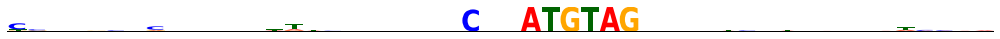

Model = 'dropout scrambler weight 10'...


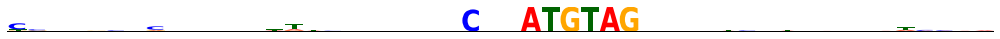

Model = 'perturbation'...


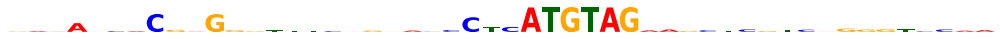

Model = 'gradient'...


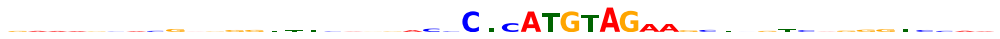

Model = 'integrated_gradients'...


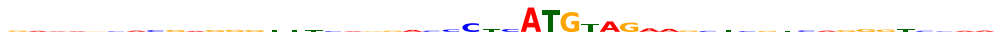

Model = 'deeplift'...


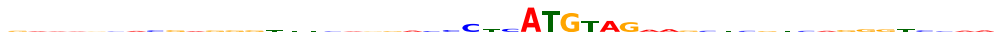

Model = 'deepshap'...


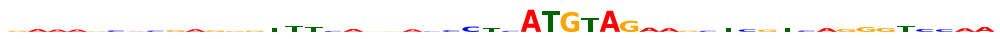

Test pattern = 34:
 - Prediction (original) = -0.7


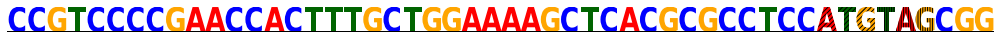

Model = 'dropout scrambler weight 1'...


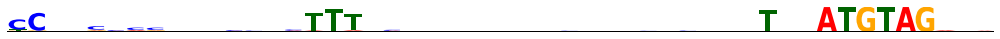

Model = 'dropout scrambler weight 10'...


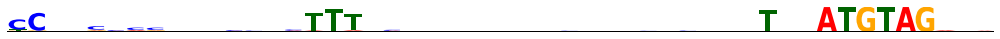

Model = 'perturbation'...


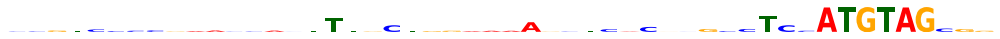

Model = 'gradient'...


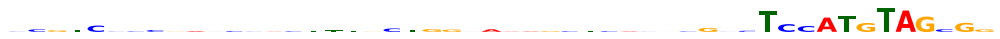

Model = 'integrated_gradients'...


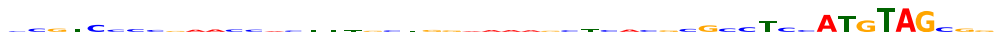

Model = 'deeplift'...


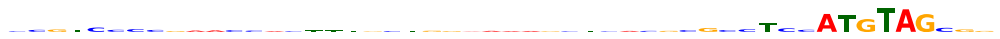

Model = 'deepshap'...


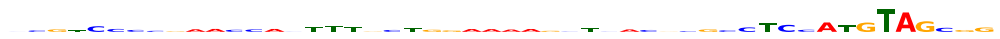

Test pattern = 35:
 - Prediction (original) = -1.3


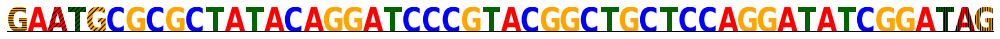

Model = 'dropout scrambler weight 1'...


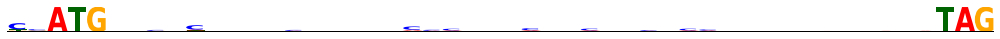

Model = 'dropout scrambler weight 10'...


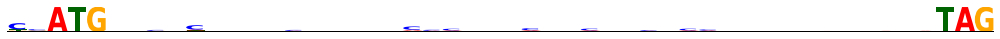

Model = 'perturbation'...


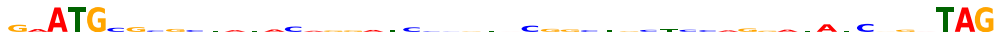

Model = 'gradient'...


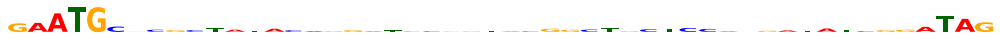

Model = 'integrated_gradients'...


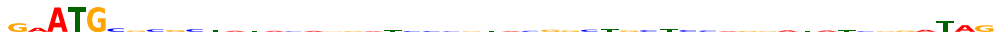

Model = 'deeplift'...


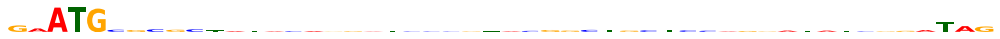

Model = 'deepshap'...


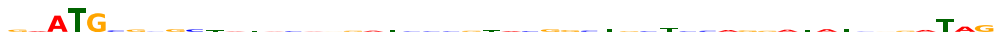

Test pattern = 36:
 - Prediction (original) = -1.0


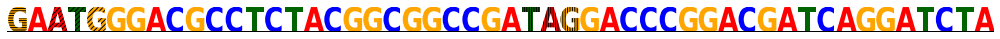

Model = 'dropout scrambler weight 1'...


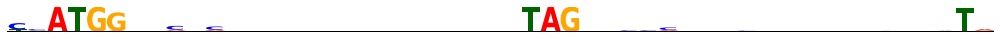

Model = 'dropout scrambler weight 10'...


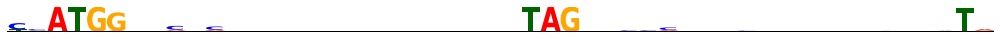

Model = 'perturbation'...


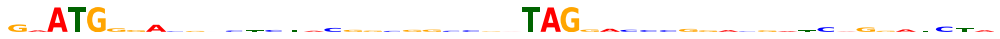

Model = 'gradient'...


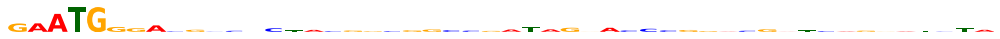

Model = 'integrated_gradients'...


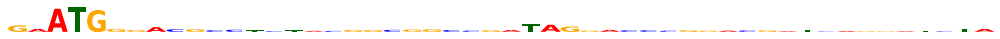

Model = 'deeplift'...


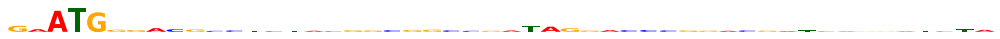

Model = 'deepshap'...


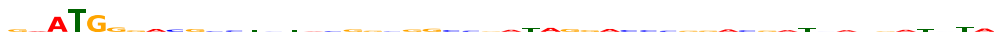

Test pattern = 37:
 - Prediction (original) = -1.6


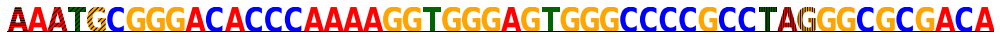

Model = 'dropout scrambler weight 1'...


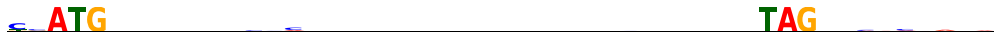

Model = 'dropout scrambler weight 10'...


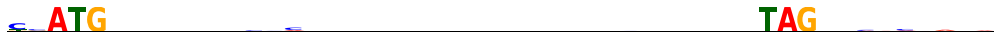

Model = 'perturbation'...


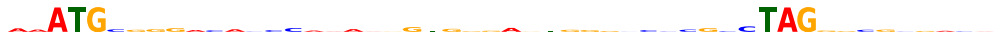

Model = 'gradient'...


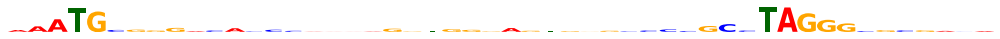

Model = 'integrated_gradients'...


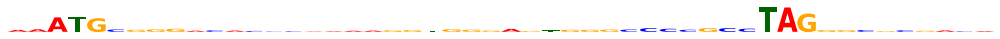

Model = 'deeplift'...


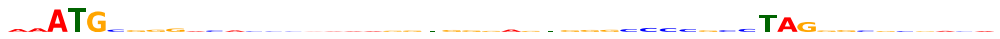

Model = 'deepshap'...


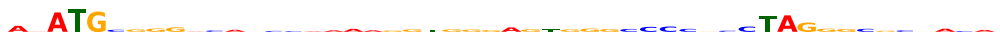

Test pattern = 38:
 - Prediction (original) = -0.4


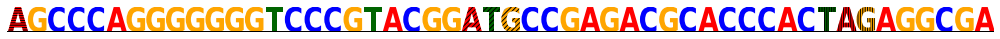

Model = 'dropout scrambler weight 1'...


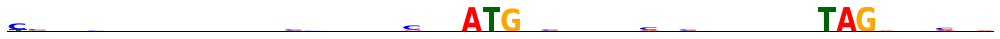

Model = 'dropout scrambler weight 10'...


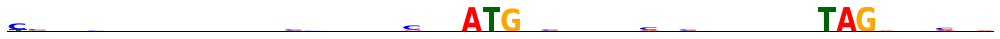

Model = 'perturbation'...


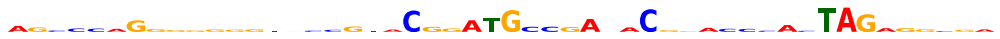

Model = 'gradient'...


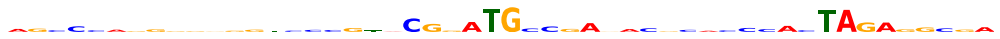

Model = 'integrated_gradients'...


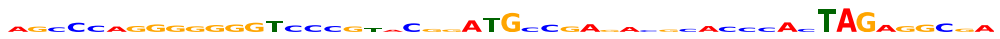

Model = 'deeplift'...


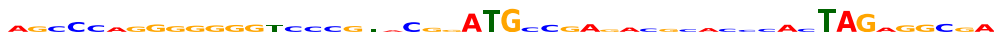

Model = 'deepshap'...


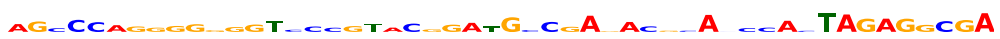

Test pattern = 39:
 - Prediction (original) = -0.8


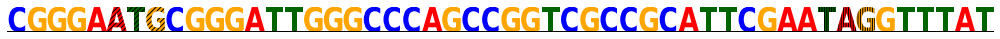

Model = 'dropout scrambler weight 1'...


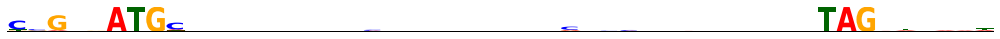

Model = 'dropout scrambler weight 10'...


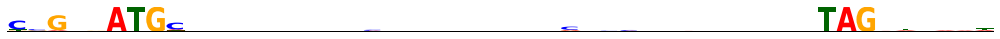

Model = 'perturbation'...


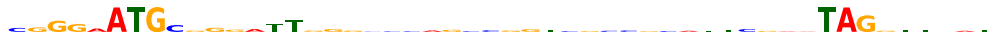

Model = 'gradient'...


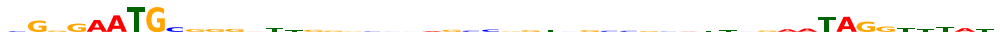

Model = 'integrated_gradients'...


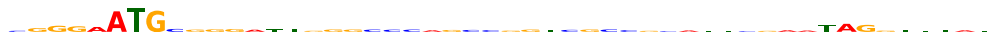

Model = 'deeplift'...


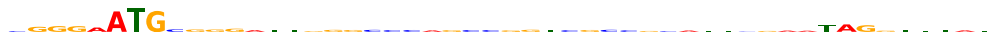

Model = 'deepshap'...


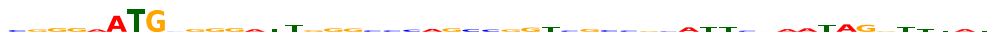

Test pattern = 40:
 - Prediction (original) = -1.4


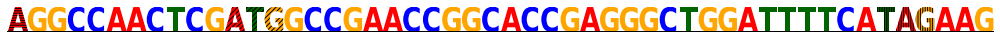

Model = 'dropout scrambler weight 1'...


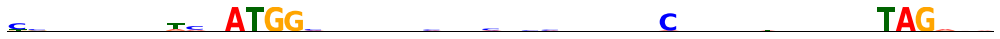

Model = 'dropout scrambler weight 10'...


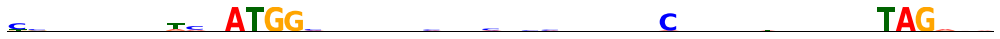

Model = 'perturbation'...


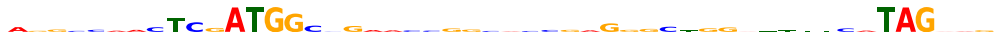

Model = 'gradient'...


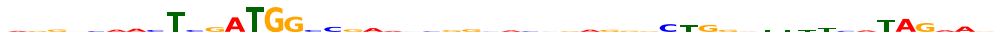

Model = 'integrated_gradients'...


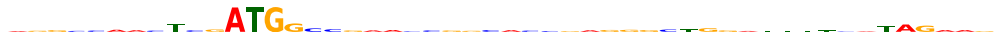

Model = 'deeplift'...


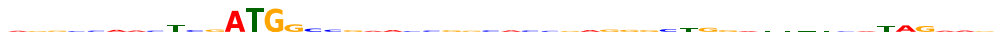

Model = 'deepshap'...


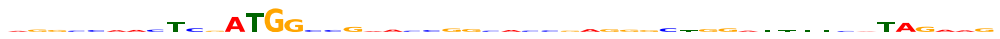

Test pattern = 41:
 - Prediction (original) = -0.3


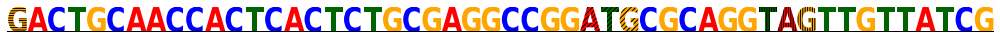

Model = 'dropout scrambler weight 1'...


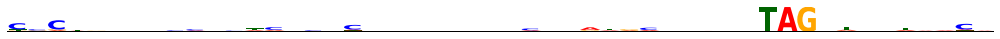

Model = 'dropout scrambler weight 10'...


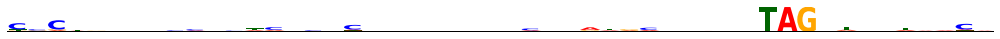

Model = 'perturbation'...


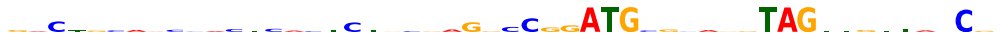

Model = 'gradient'...


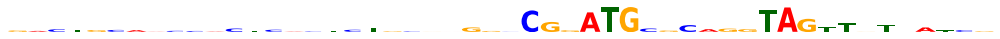

Model = 'integrated_gradients'...


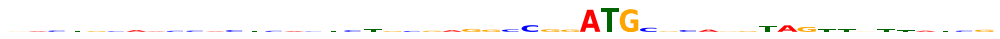

Model = 'deeplift'...


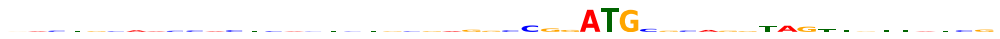

Model = 'deepshap'...


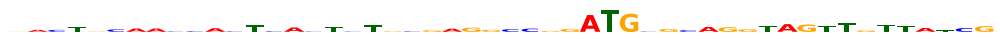

Test pattern = 42:
 - Prediction (original) = -1.2


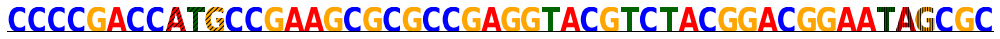

Model = 'dropout scrambler weight 1'...


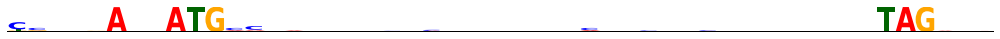

Model = 'dropout scrambler weight 10'...


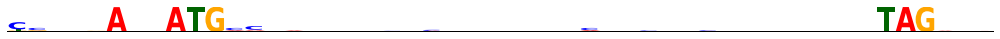

Model = 'perturbation'...


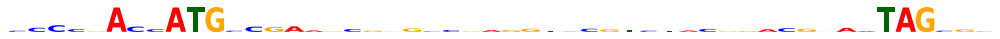

Model = 'gradient'...


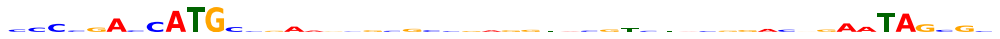

Model = 'integrated_gradients'...


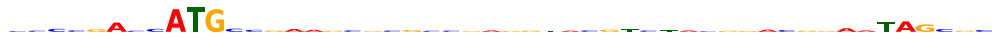

Model = 'deeplift'...


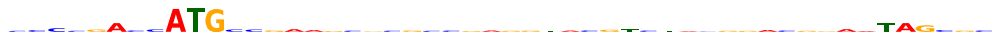

Model = 'deepshap'...


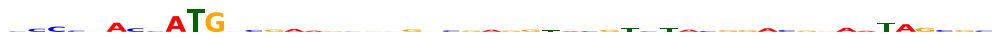

Test pattern = 43:
 - Prediction (original) = -2.0


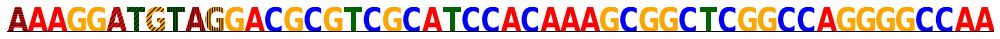

Model = 'dropout scrambler weight 1'...


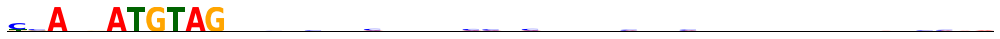

Model = 'dropout scrambler weight 10'...


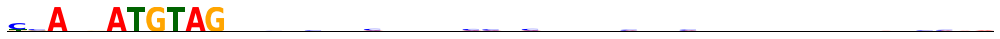

Model = 'perturbation'...


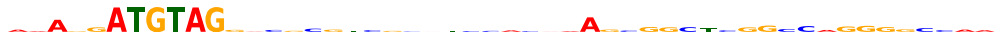

Model = 'gradient'...


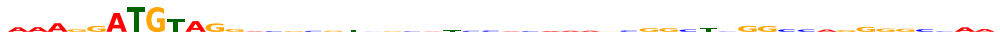

Model = 'integrated_gradients'...


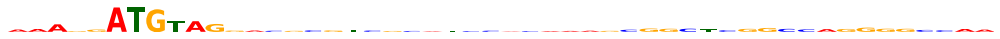

Model = 'deeplift'...


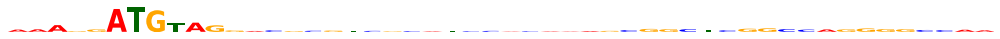

Model = 'deepshap'...


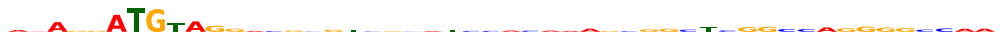

Test pattern = 44:
 - Prediction (original) = -0.3


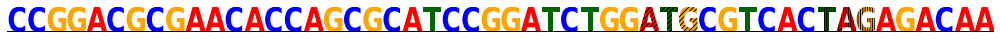

Model = 'dropout scrambler weight 1'...


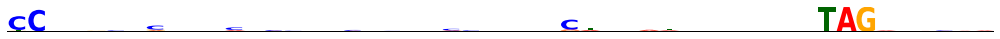

Model = 'dropout scrambler weight 10'...


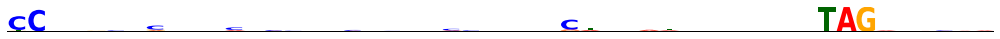

Model = 'perturbation'...


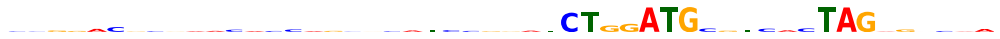

Model = 'gradient'...


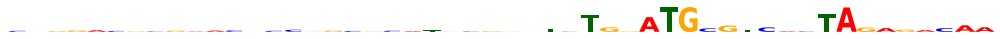

Model = 'integrated_gradients'...


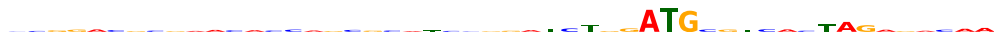

Model = 'deeplift'...


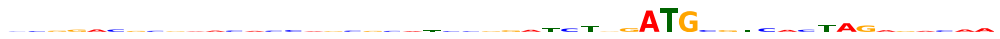

Model = 'deepshap'...


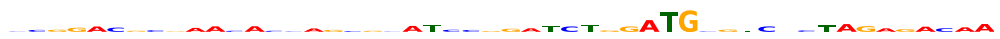

Test pattern = 45:
 - Prediction (original) = -0.6


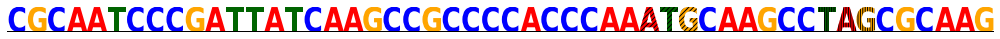

Model = 'dropout scrambler weight 1'...


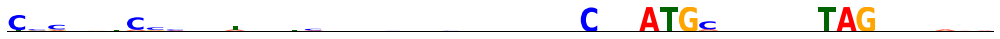

Model = 'dropout scrambler weight 10'...


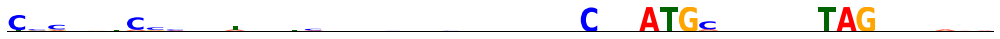

Model = 'perturbation'...


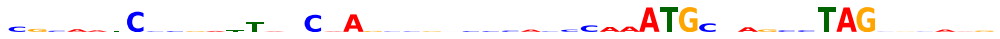

Model = 'gradient'...


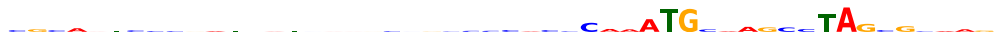

Model = 'integrated_gradients'...


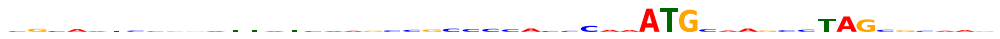

Model = 'deeplift'...


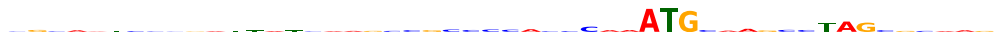

Model = 'deepshap'...


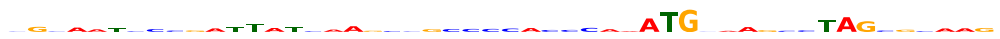

Test pattern = 46:
 - Prediction (original) = -0.9


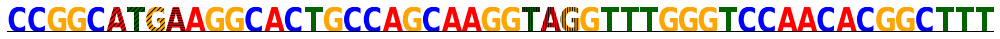

Model = 'dropout scrambler weight 1'...


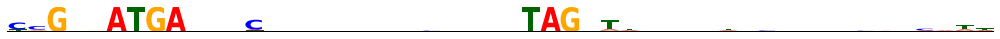

Model = 'dropout scrambler weight 10'...


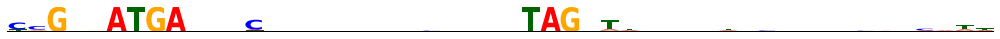

Model = 'perturbation'...


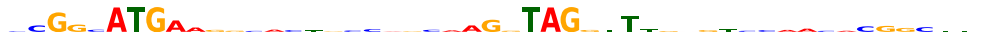

Model = 'gradient'...


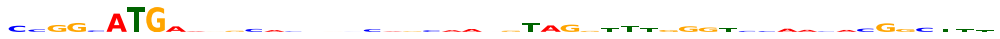

Model = 'integrated_gradients'...


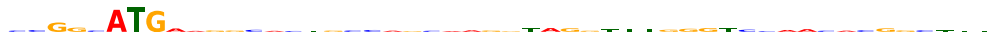

Model = 'deeplift'...


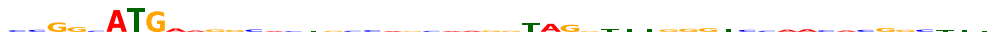

Model = 'deepshap'...


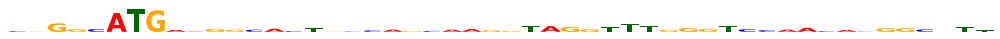

Test pattern = 47:
 - Prediction (original) = -1.0


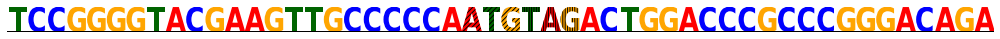

Model = 'dropout scrambler weight 1'...


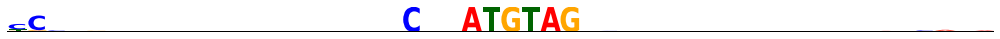

Model = 'dropout scrambler weight 10'...


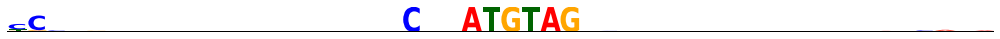

Model = 'perturbation'...


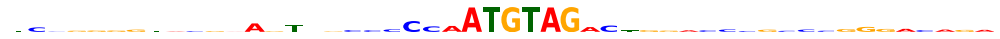

Model = 'gradient'...


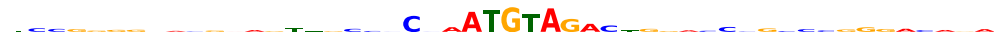

Model = 'integrated_gradients'...


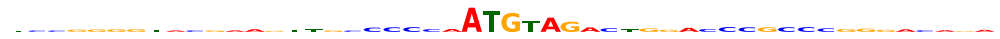

Model = 'deeplift'...


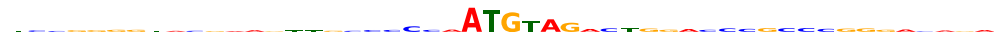

Model = 'deepshap'...


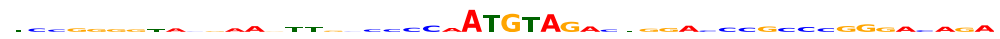

Test pattern = 48:
 - Prediction (original) = -1.1


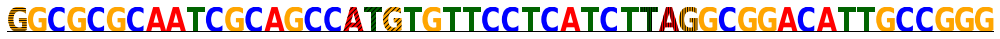

Model = 'dropout scrambler weight 1'...


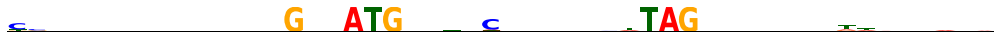

Model = 'dropout scrambler weight 10'...


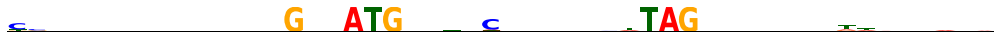

Model = 'perturbation'...


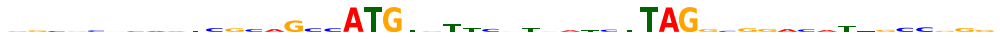

Model = 'gradient'...


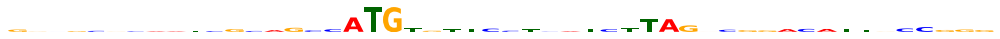

Model = 'integrated_gradients'...


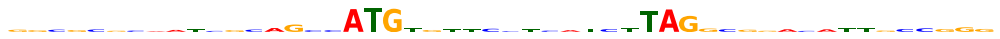

Model = 'deeplift'...


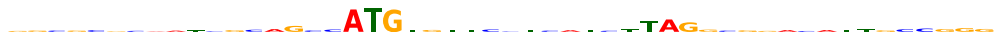

Model = 'deepshap'...


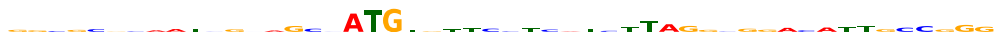

Test pattern = 49:
 - Prediction (original) = -0.5


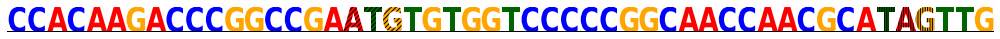

Model = 'dropout scrambler weight 1'...


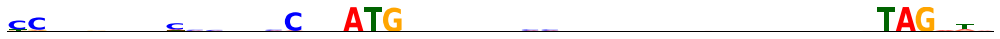

Model = 'dropout scrambler weight 10'...


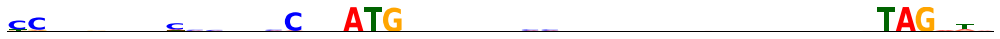

Model = 'perturbation'...


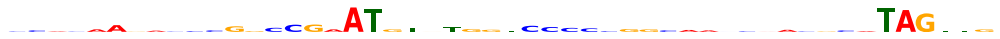

Model = 'gradient'...


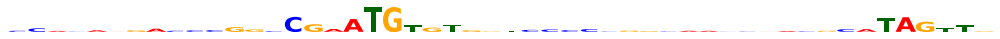

Model = 'integrated_gradients'...


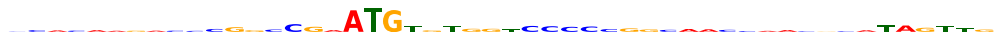

Model = 'deeplift'...


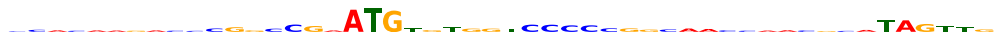

Model = 'deepshap'...


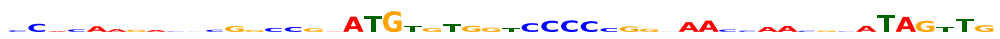

In [23]:
#Visualize a few example patterns

#Visualize a few example patterns
from sequence_logo_helper import dna_letter_at, plot_dna_logo, plot_dna_logo_orig, plot_dna_logo_to_file, plot_dna_logo_orig_to_file



save_figs = False



plot_examples = list(range(0,50))
feature_quantiles = [0.76, 0.82, 0.88]

score_clips = [
    None,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5
]

on_state_logit_val = 50.

encoder = isol.OneHotEncoder(50)

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)

for data_ix in plot_examples :
    
    print("Test pattern = " + str(data_ix) + ":")
    #orig is (3008,1,50,4)
    #x_test[data_ix, 0, :, :] is (50,4)
    justPred = np.expand_dims(np.expand_dims(x_test[data_ix, 0, :, :], axis=0), axis=-1)
    justPredReshape = np.reshape(justPred, (1,50,4))
    
    #y_test_hat_ref = predictor.predict(x=[np.expand_dims(np.expand_dims(x_test[data_ix, 0, :, :], axis=0))], batch_size=1)[0][0, 0]
    y_test_hat_ref = predictor.predict(x=justPredReshape, batch_size=1)[0][0]
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    
    #plot_dna_logo_(x_test[data_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_test_ix_" + str(data_ix))
    plot_dna_logo_orig(x_test[data_ix, 0, :, :], data_df.iloc[data_ix]['utr'], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=50)
    
    for model_i in range(len(model_names)) :

        print("Model = '" + str(model_names[model_i]) + "'...")
        #print ("average MSE: ", data_df.iloc[data_ix][model_names[model_i]+ "_50_quantile_MSE"])
        #print (" best performer: ", data_df.iloc[data_ix]["BestPerformingModelMSE"])

        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][1, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        if 'scrambler' in model_names[model_i] :
            
            #make a prediction with the original sequence & plot the resulting PWM 
            if "125" in model_names[model_i]:
                #plot_dna_logo_to_file(pwm, fileName, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164)
                #plot_dna_logo_to_file(pwm, fileName, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164)
                fig_name="./exampleImages6_8_10_12/benchmark_inclusion_pwm_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i]
                plot_dna_logo(pwm_test_0125[data_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=50)
            else:
                fig_name="./exampleImages6_8_10_12/benchmark_inclusion_pwm_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i]
                plot_dna_logo(pwm_test_025[data_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=50)
            
        else :
            
            plot_importance_scores(importance_scores_test[data_ix, 0, :, :].T, encoder.decode(x_test[data_ix, 0, :, :]), figsize=(14, 0.65), score_clip=score_clips[model_i], sequence_template=sequence_template, plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="./exampleImages6_8_10_12/benchmark_inclusion_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i])
